In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("/Users/fasilck/SARIMAX_MODEL/train 2.csv",parse_dates=["date"],index_col=["date"])
df.head()

store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10

In [3]:
monthly_sales = df.resample('M').sum()

In [4]:
monthly_sales.head()

store    item   sales
date                             
2013-01-31  85250  395250  454904
2013-02-28  77000  357000  459417
2013-03-31  85250  395250  617382
2013-04-30  82500  382500  682274
2013-05-31  85250  395250  763242

<Axes: xlabel='date'>

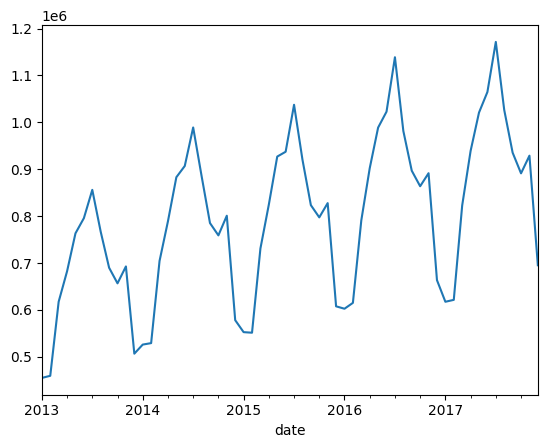

In [5]:
monthly_sales["sales"].plot()

In [6]:
monthly_sales.isnull().sum()

store    0
item     0
sales    0
dtype: int64

In [7]:
ts=pd.DataFrame(monthly_sales,columns=["sales"])
ts.head()

sales
date              
2013-01-31  454904
2013-02-28  459417
2013-03-31  617382
2013-04-30  682274
2013-05-31  763242

In [8]:
import statsmodels.api as sm

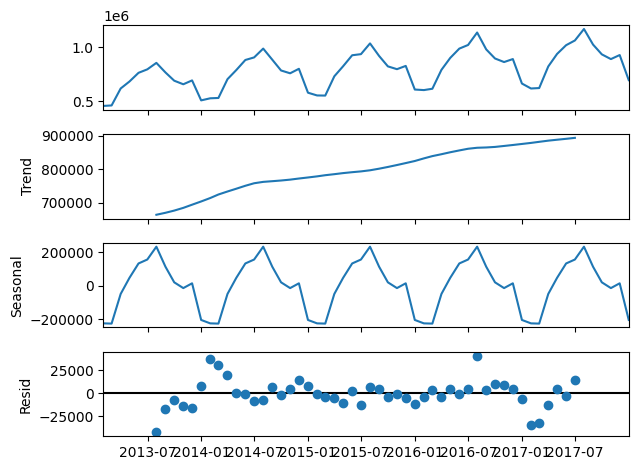

In [9]:
decomposition=sm.tsa.seasonal_decompose(ts,model="additive")
fig=decomposition.plot()
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller

In [12]:
test_result=adfuller(monthly_sales['sales'])

In [13]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [14]:
adfuller_test(monthly_sales['sales'])

ADF Test Statistic : -5.247518850016344
p-value : 7.0264953915749874e-06
#Lags Used : 11
Number of Observations Used : 48
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


 adfuller test saying it is stationary. but it does not seems stationary during visualization. So we go for further test to get the p,d,q values.
1)acf,pacf test.
2)for loop

In [15]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [16]:
import statsmodels.api as sm

##Final Thoughts on Autocorrelation and Partial Autocorrelation

####Identification of an AR model is often best done with the PACF.
  For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
####Identification of an MA model is often best done with the ACF rather than the PACF.
  For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.
p,d,q p AR model lags d differencing q MA lags

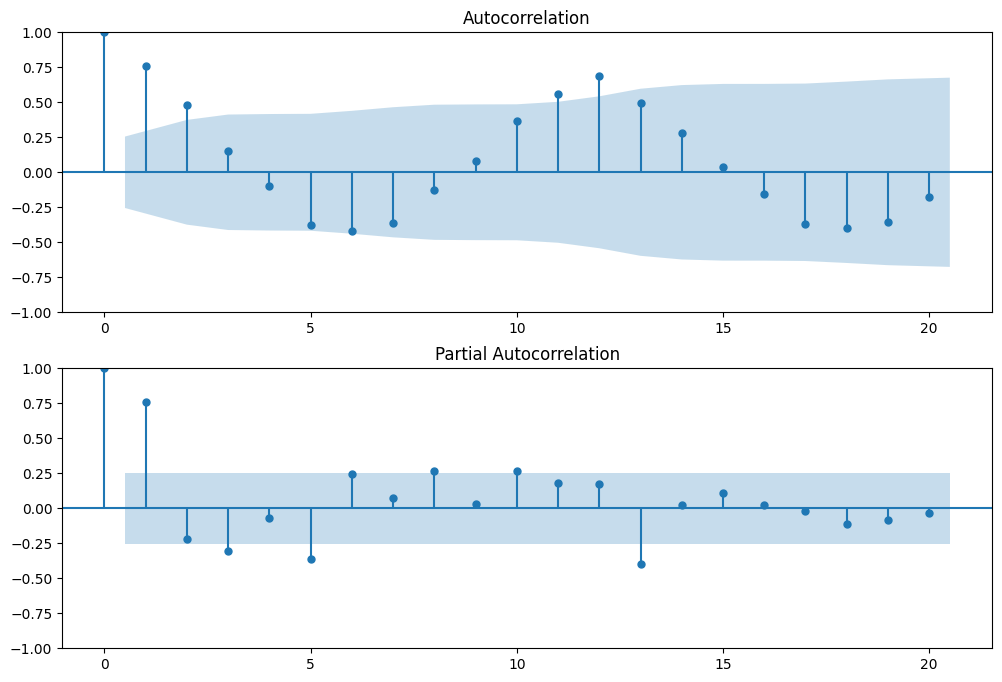

In [17]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(monthly_sales["sales"].iloc[1:],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(monthly_sales['sales'].iloc[1:],lags=20,ax=ax2)

In [ ]:
## by using for loop for different combination of p,d,q we got the order (1,0,1) having least RMSE.

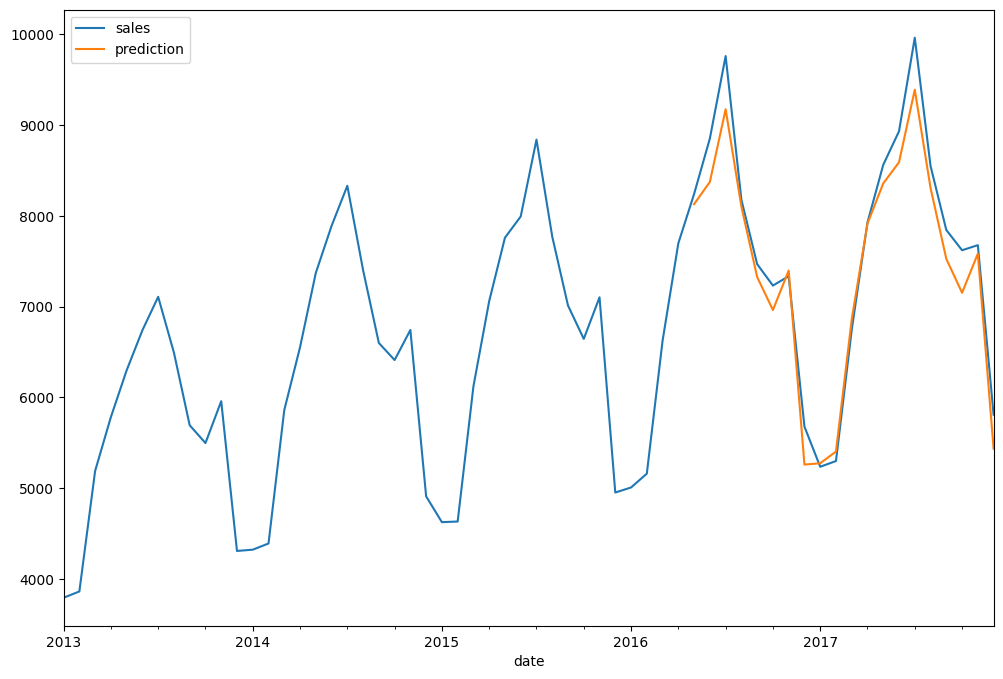

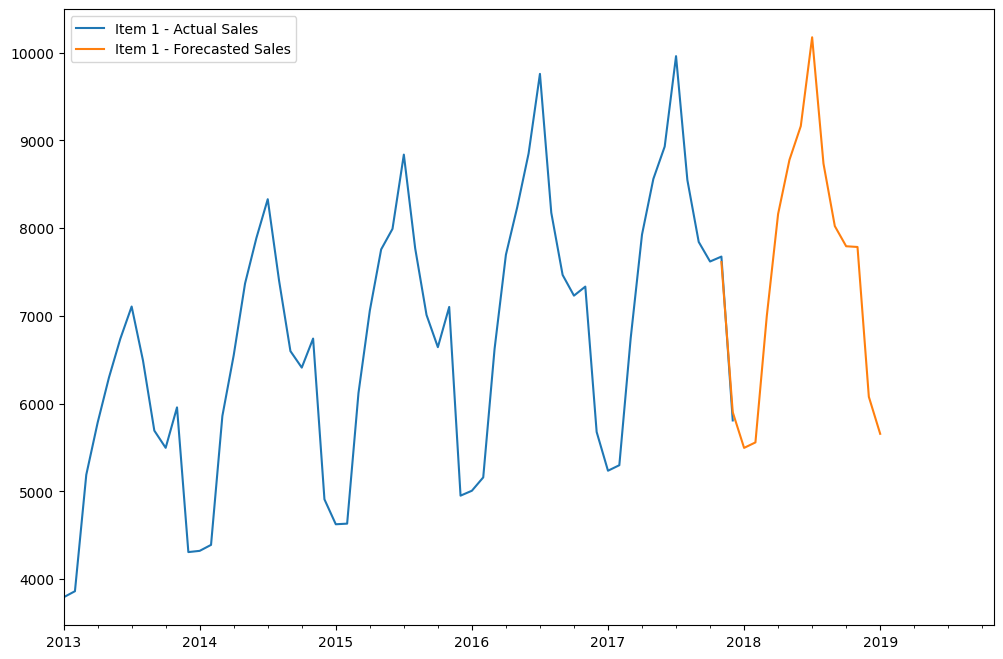

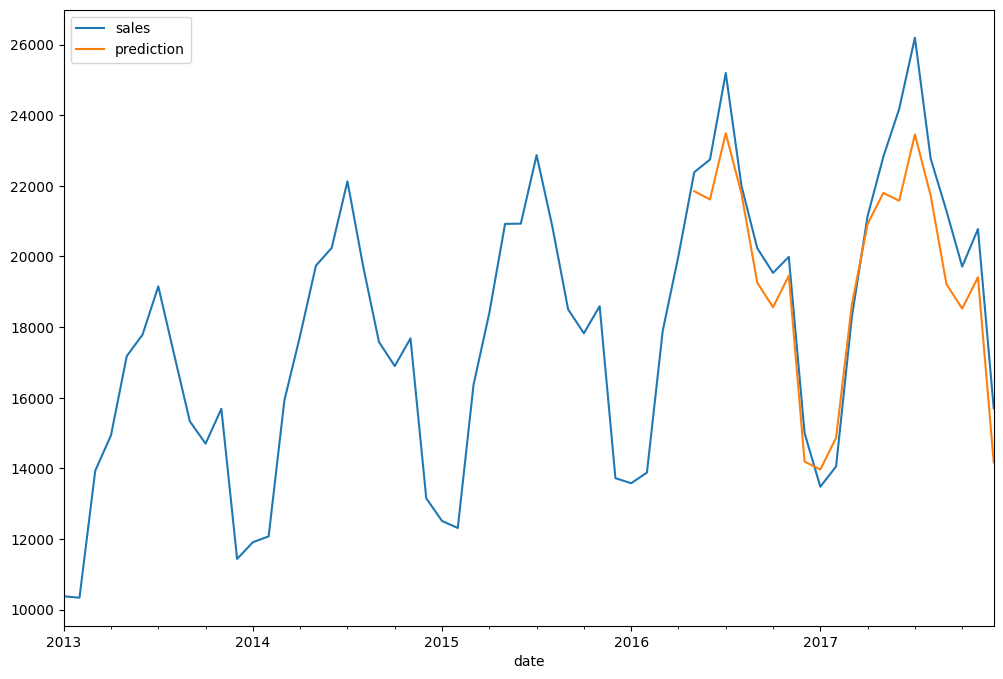

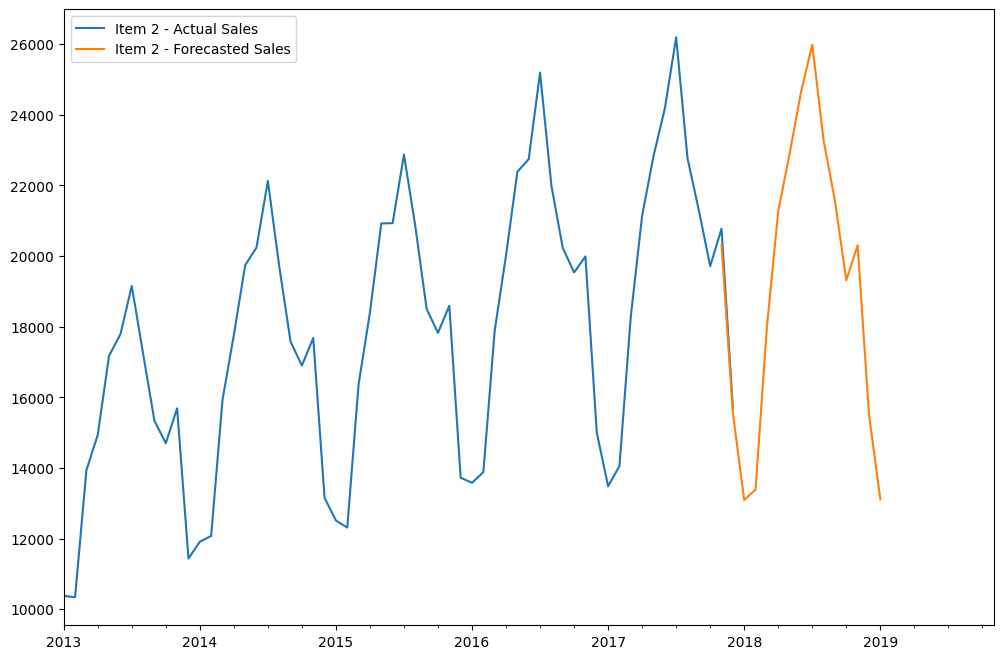

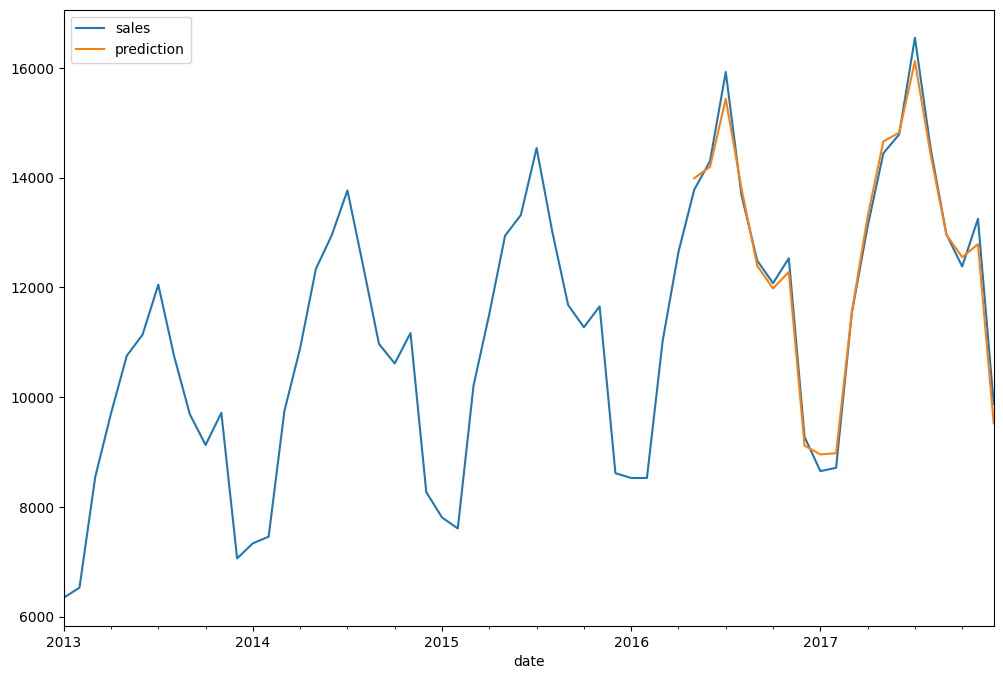

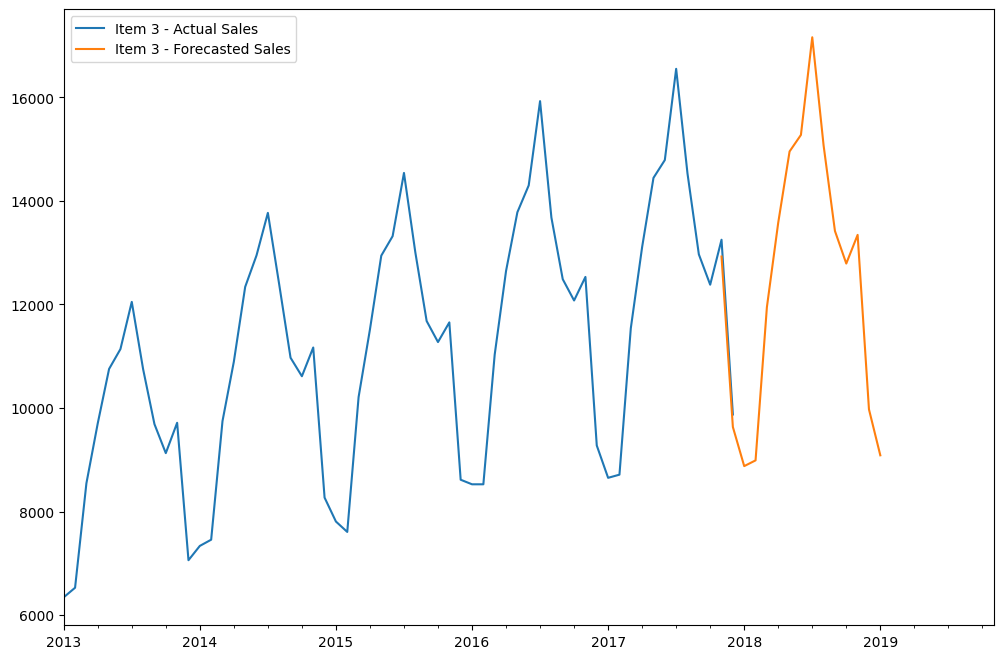

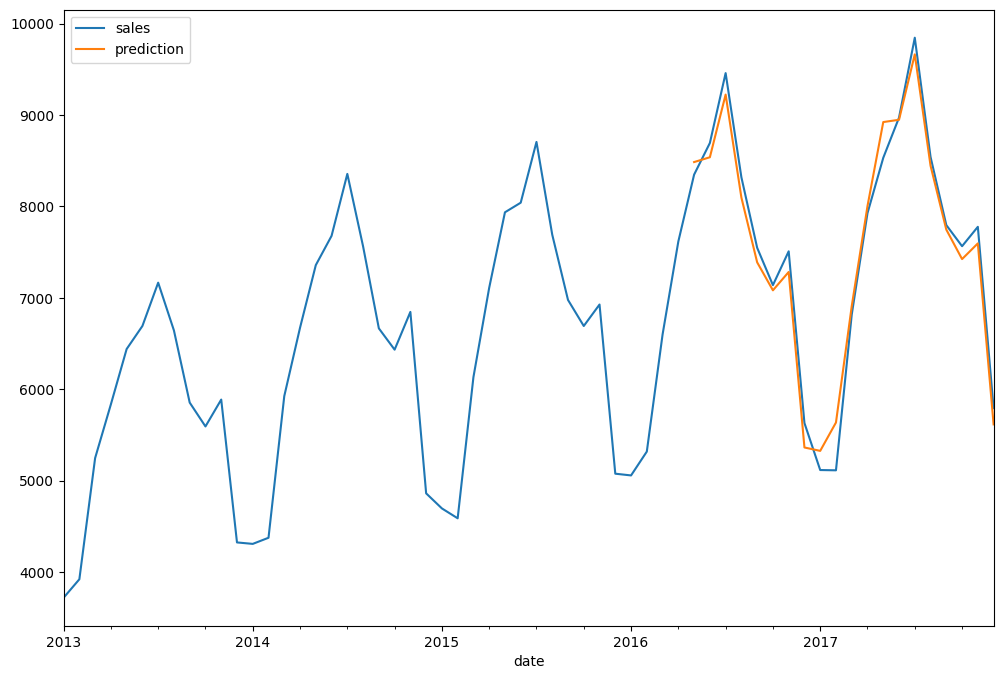

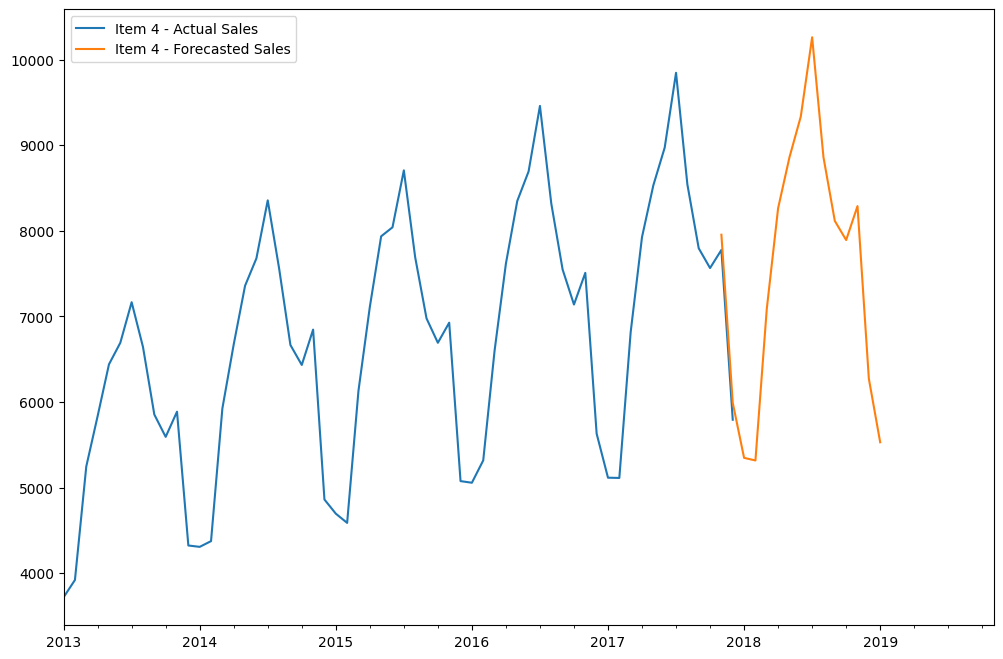

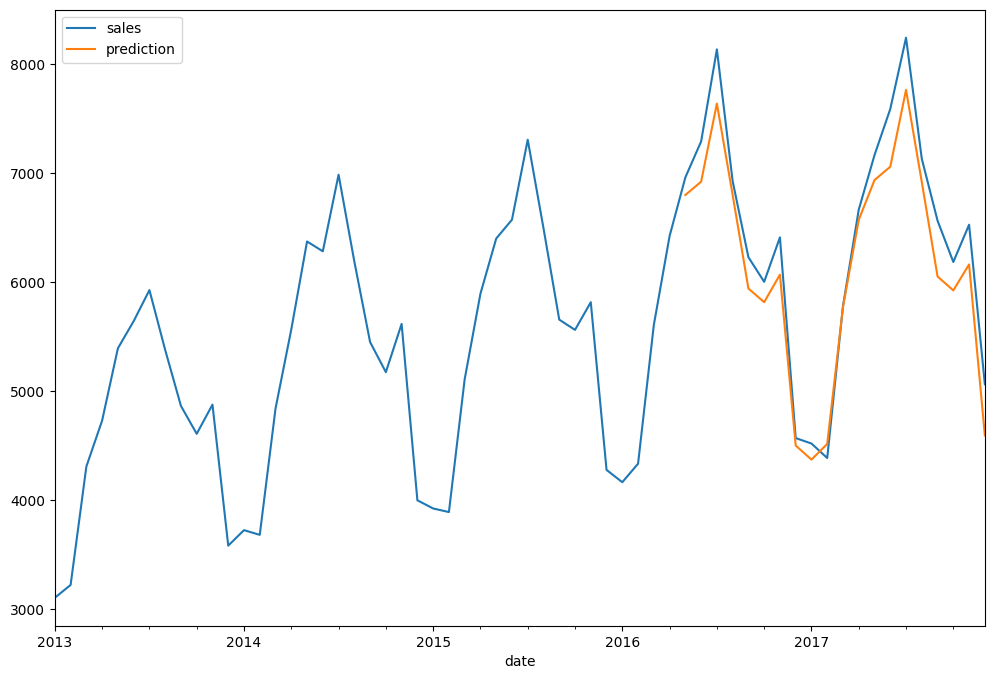

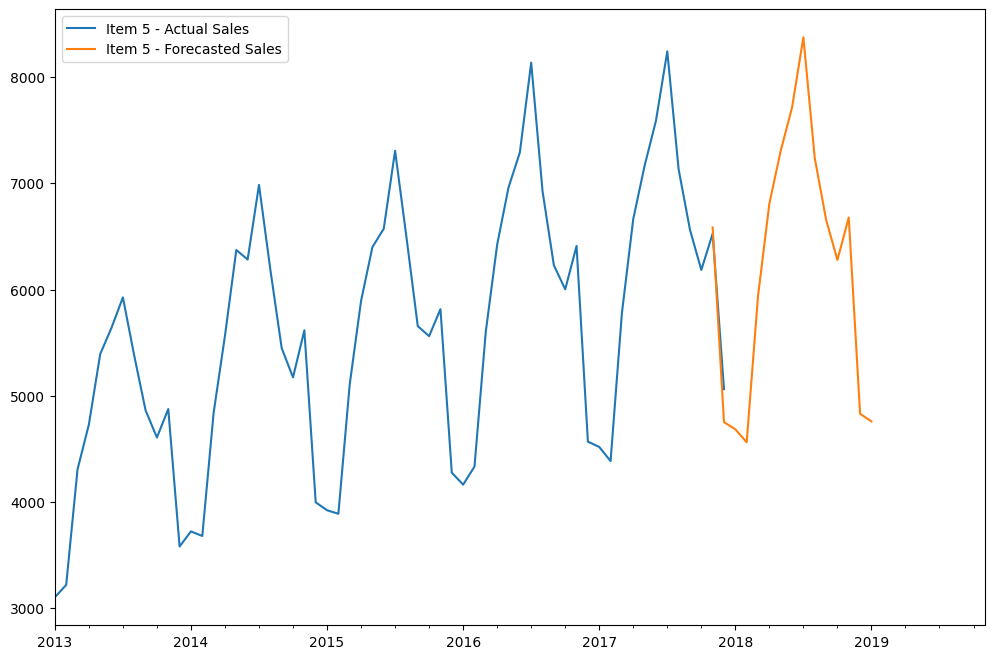

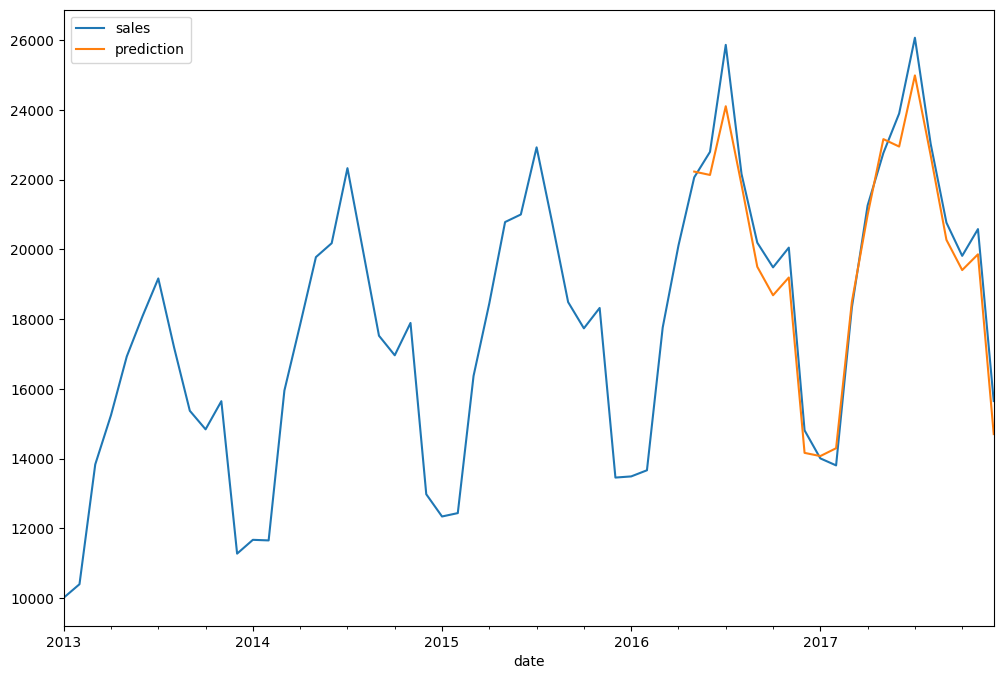

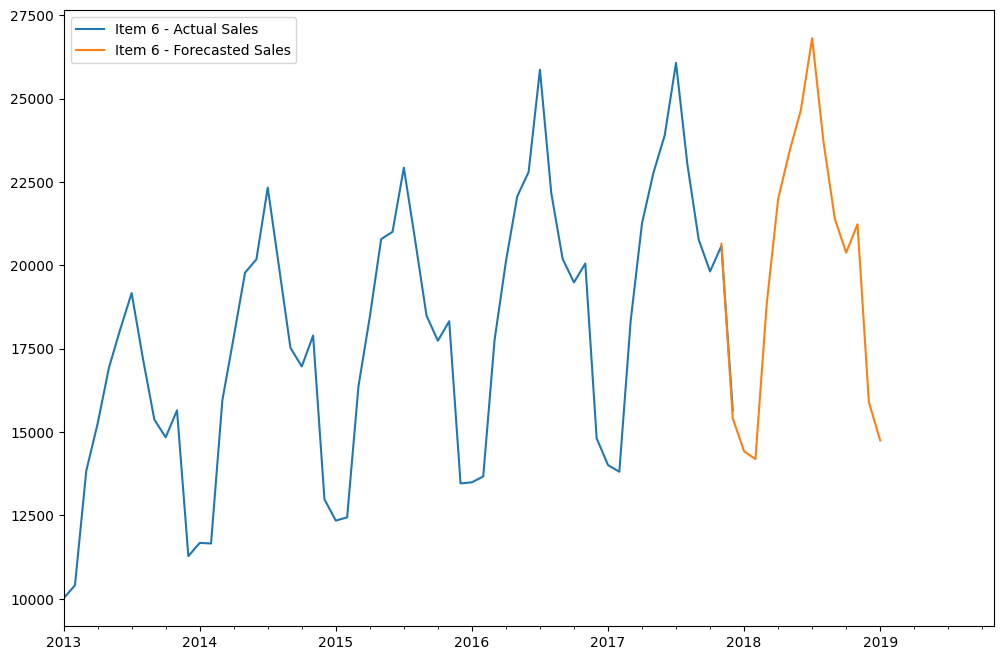

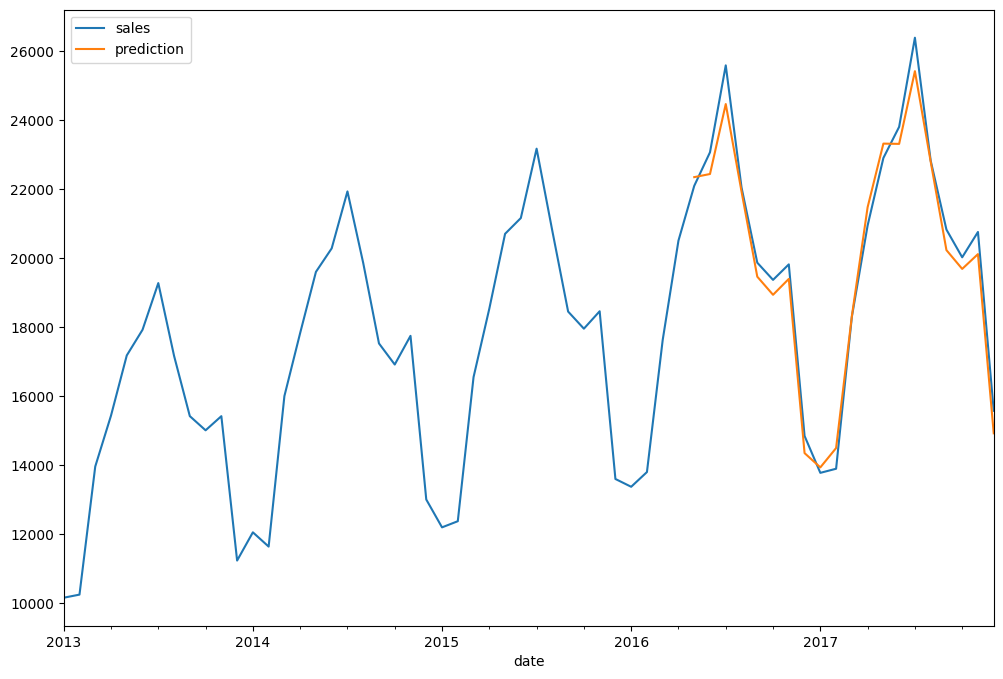

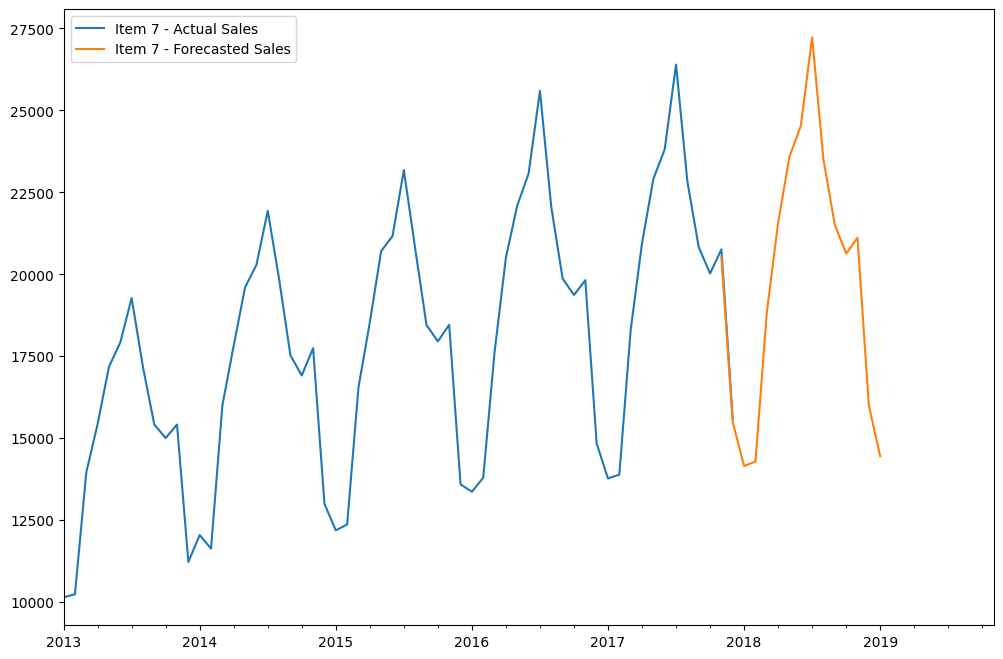

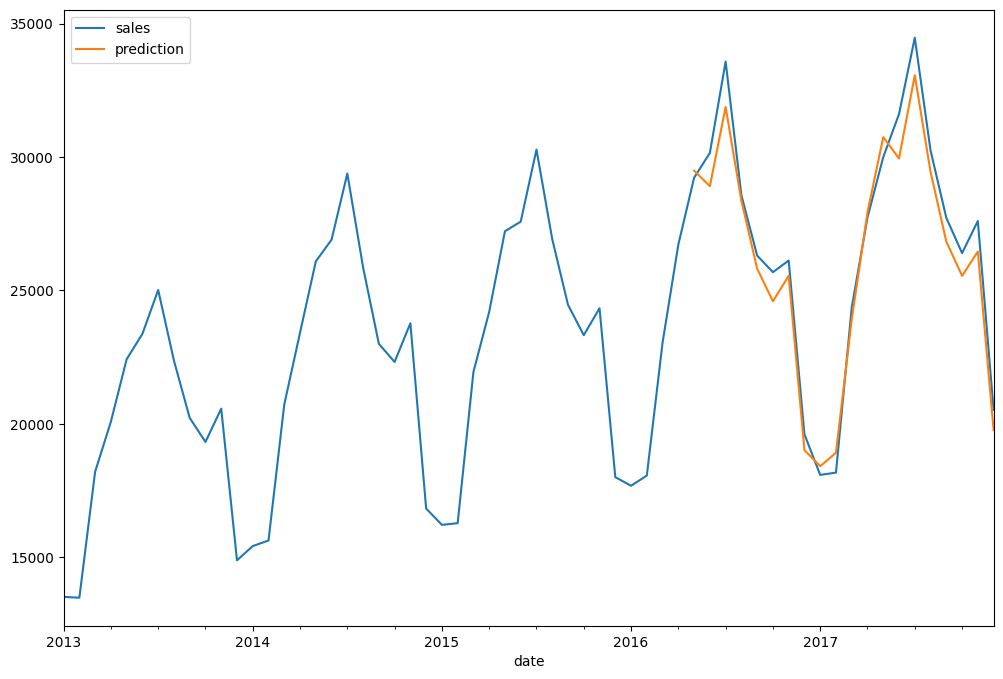

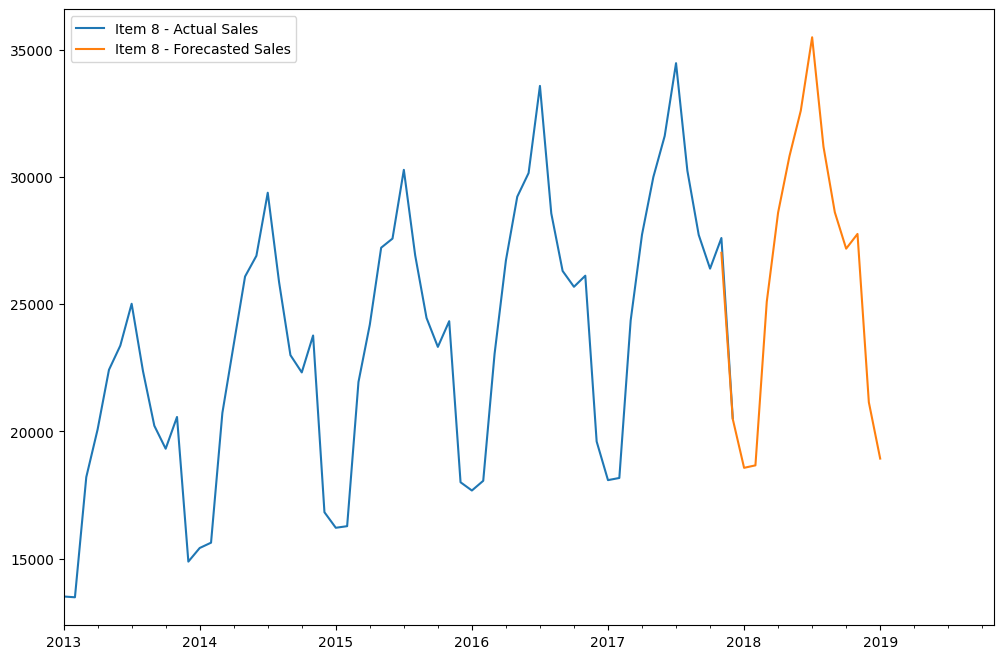

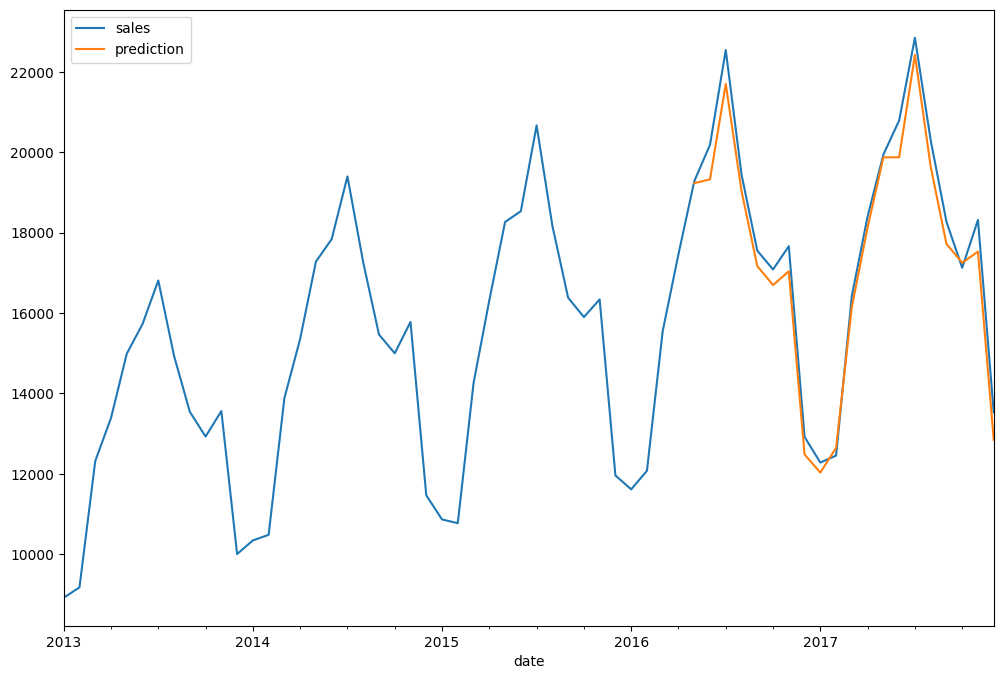

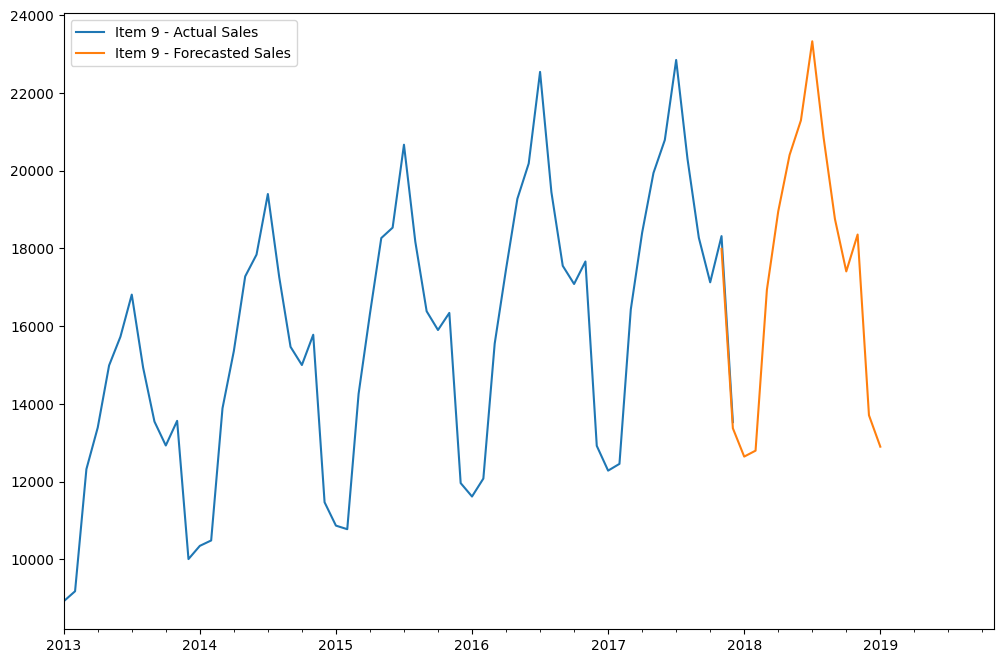

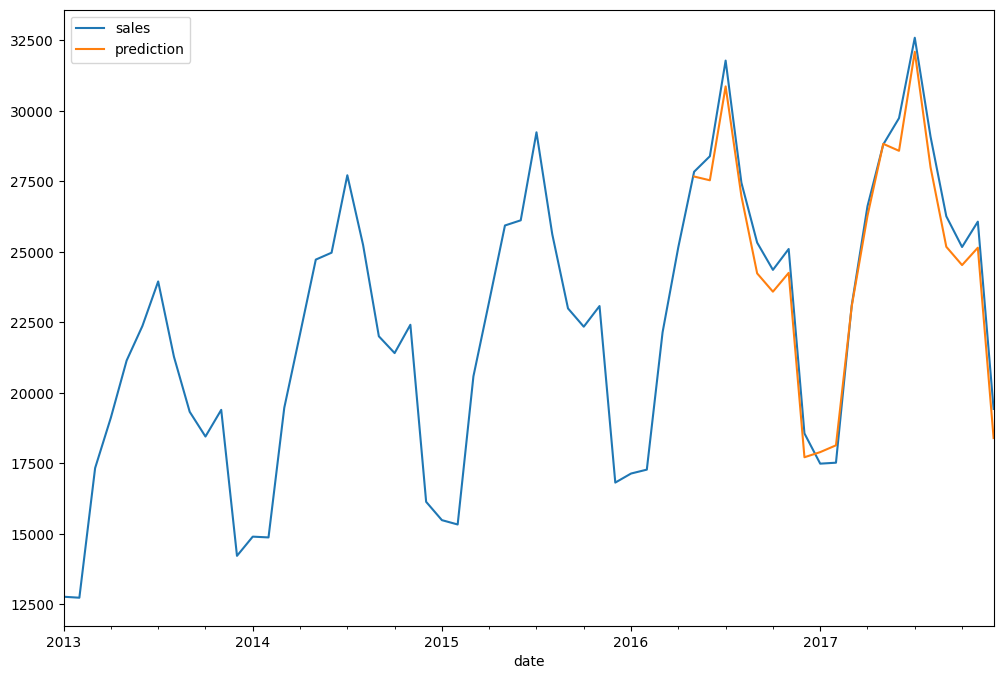

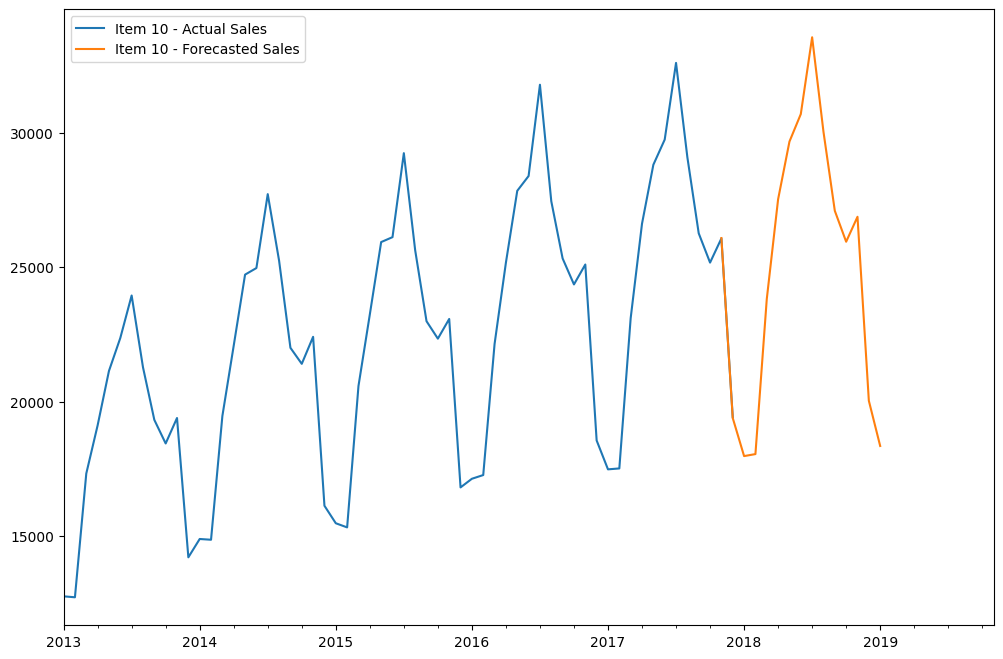

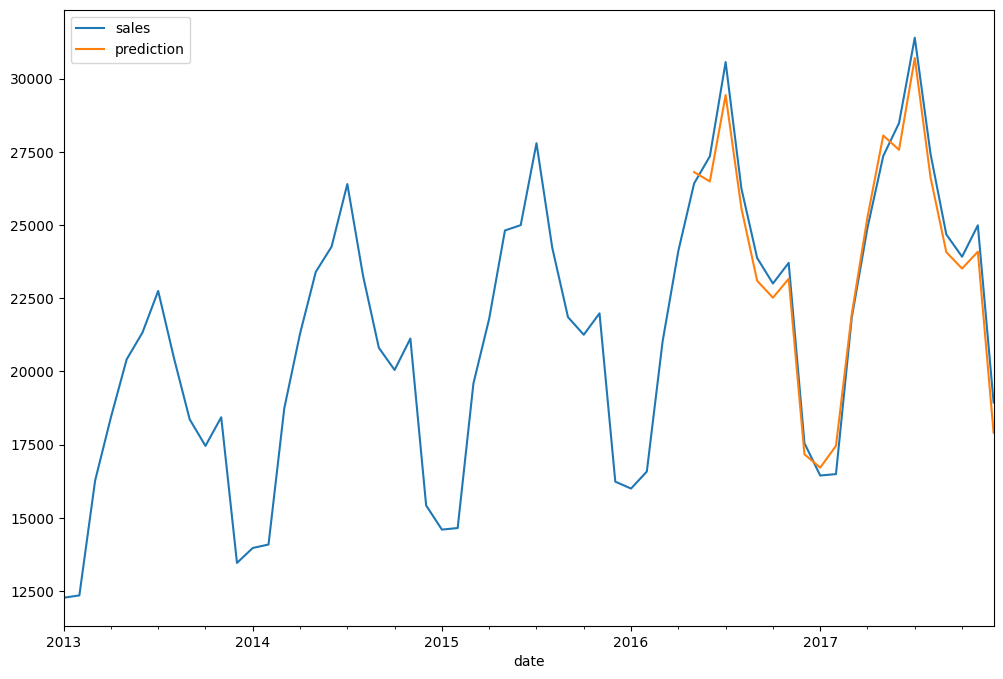

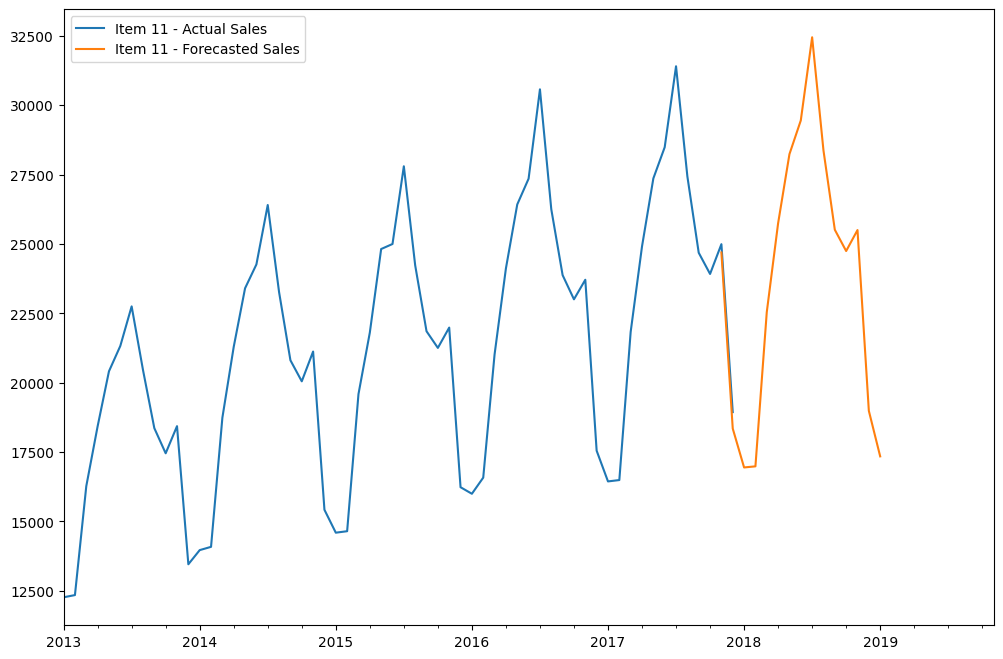

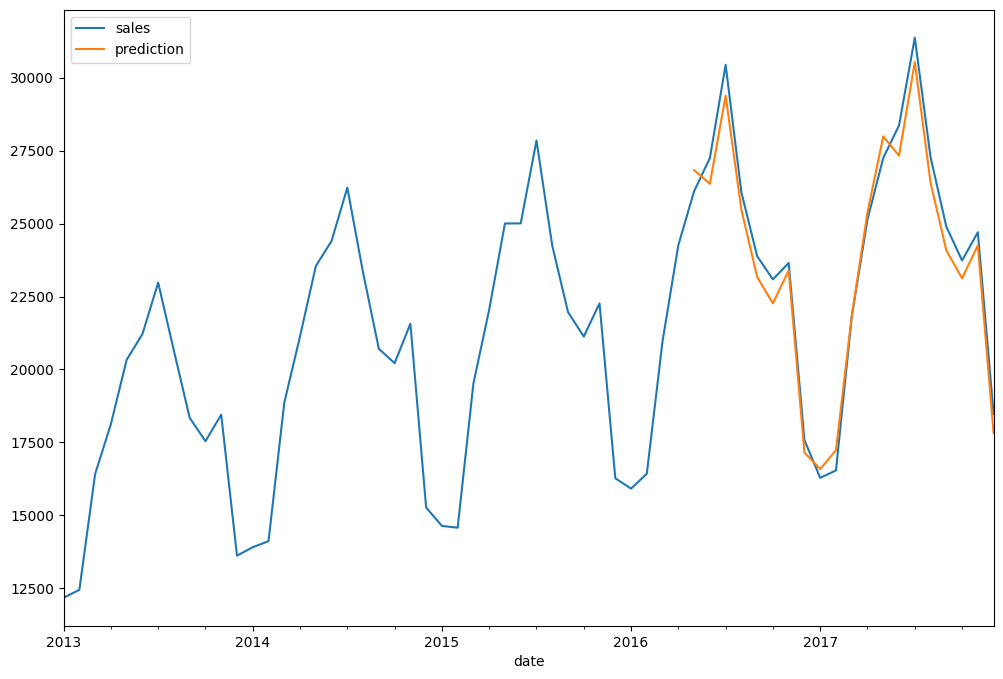

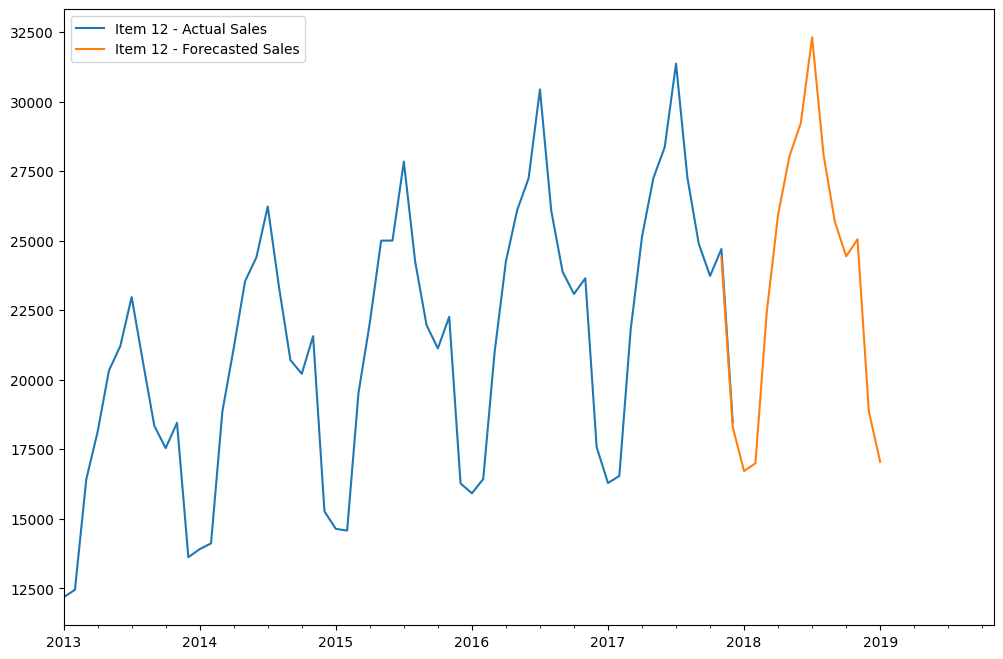

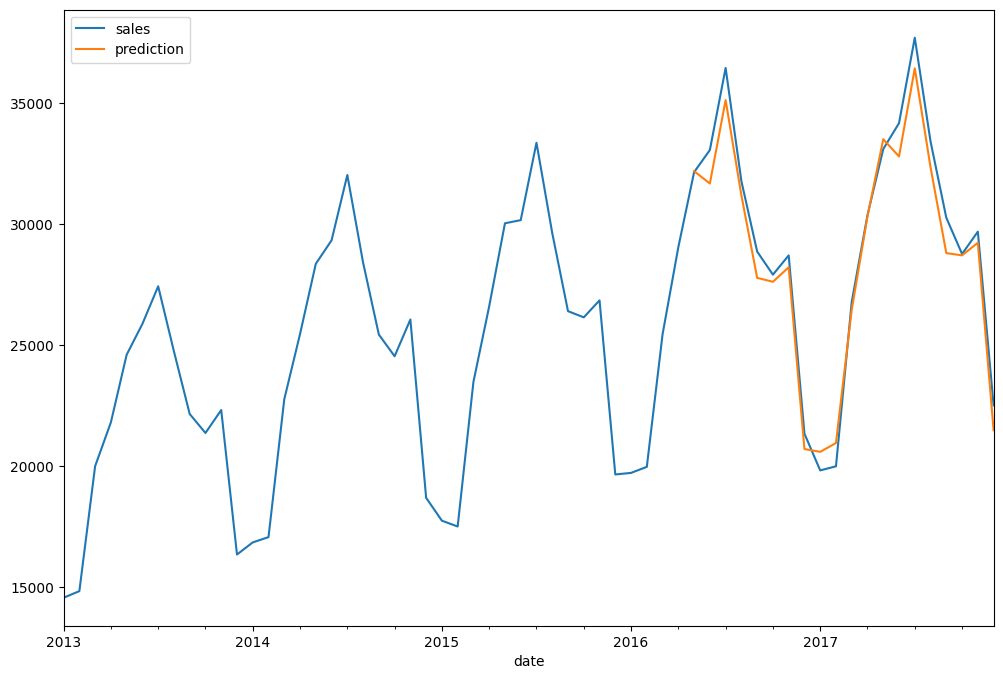

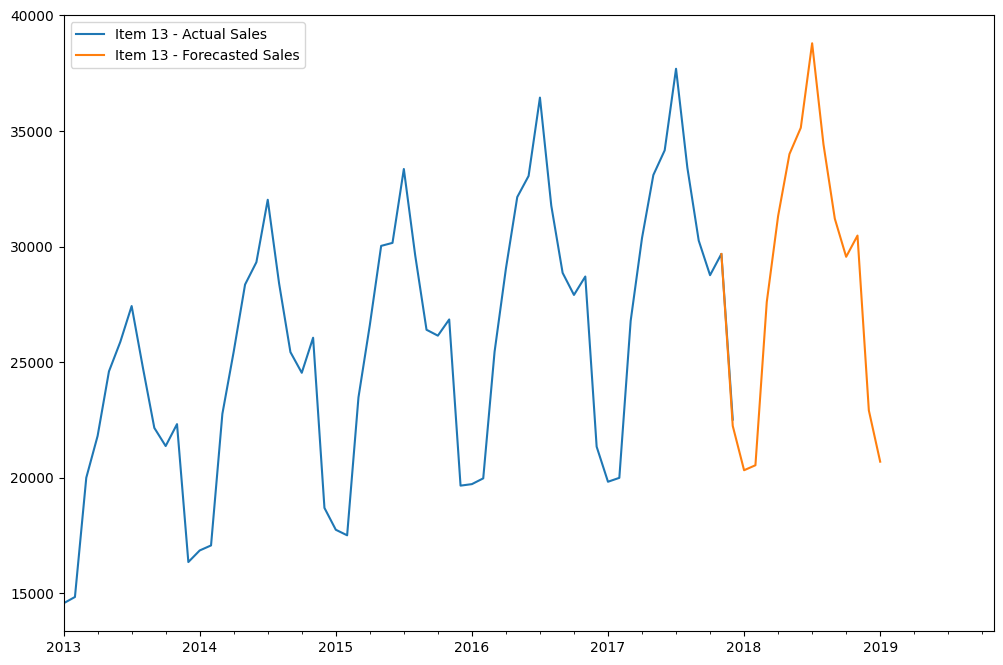

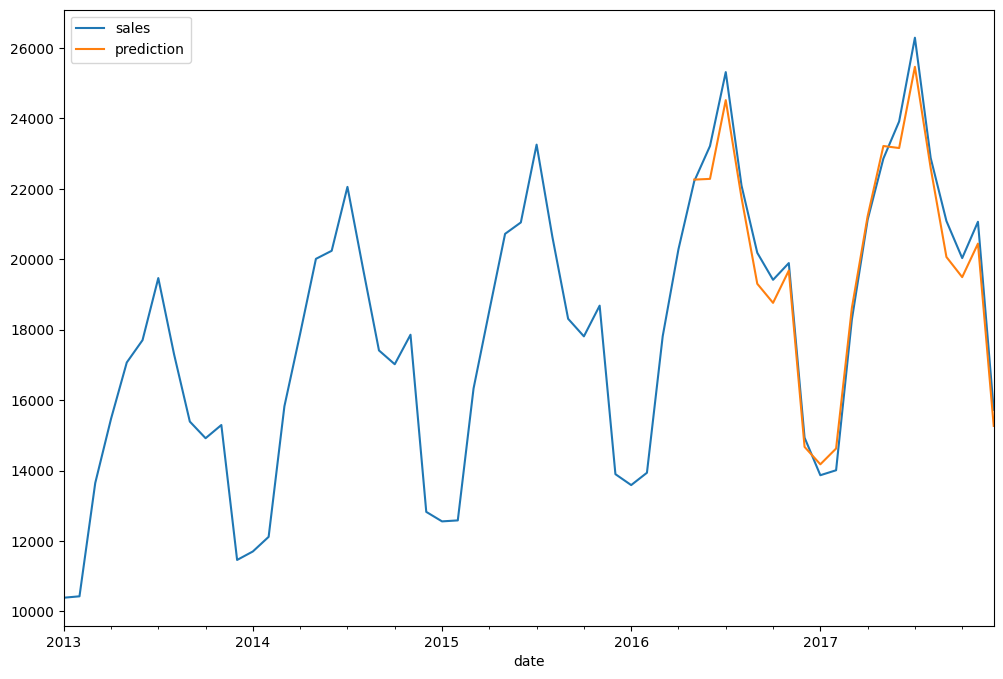

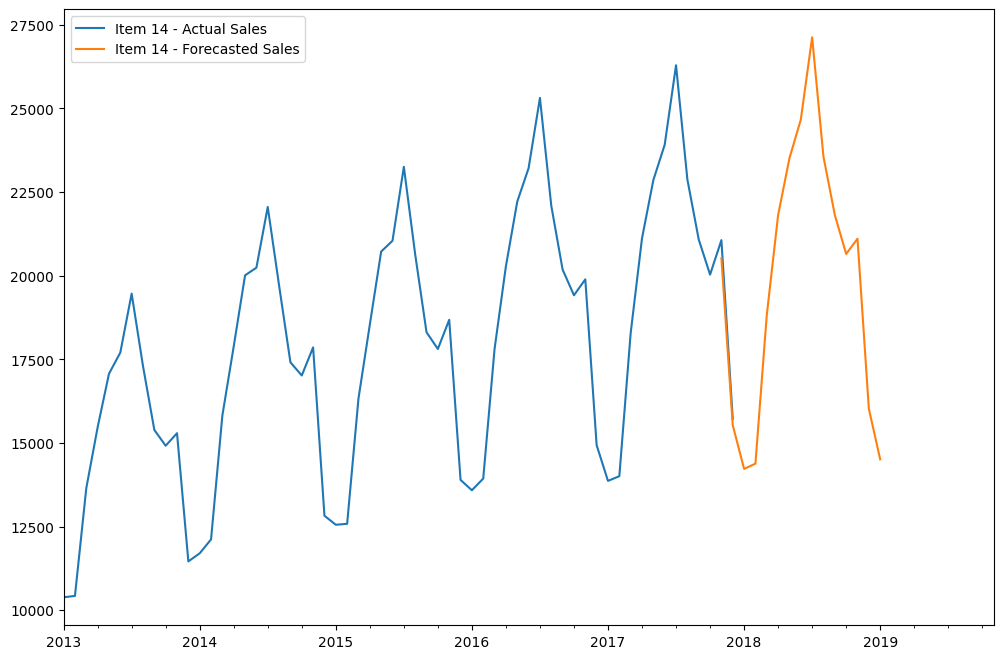

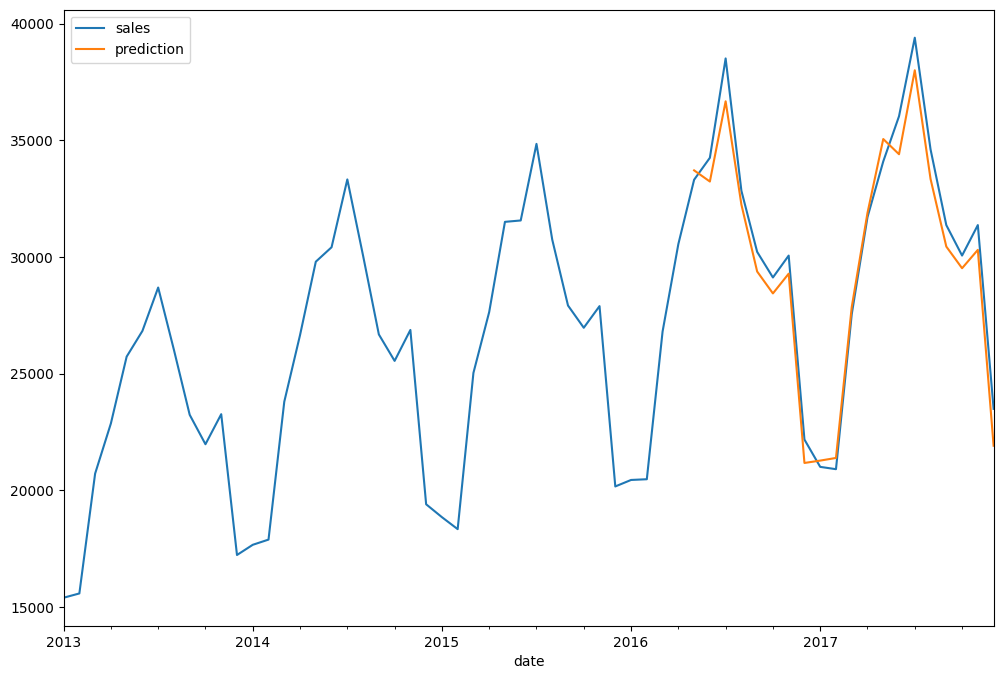

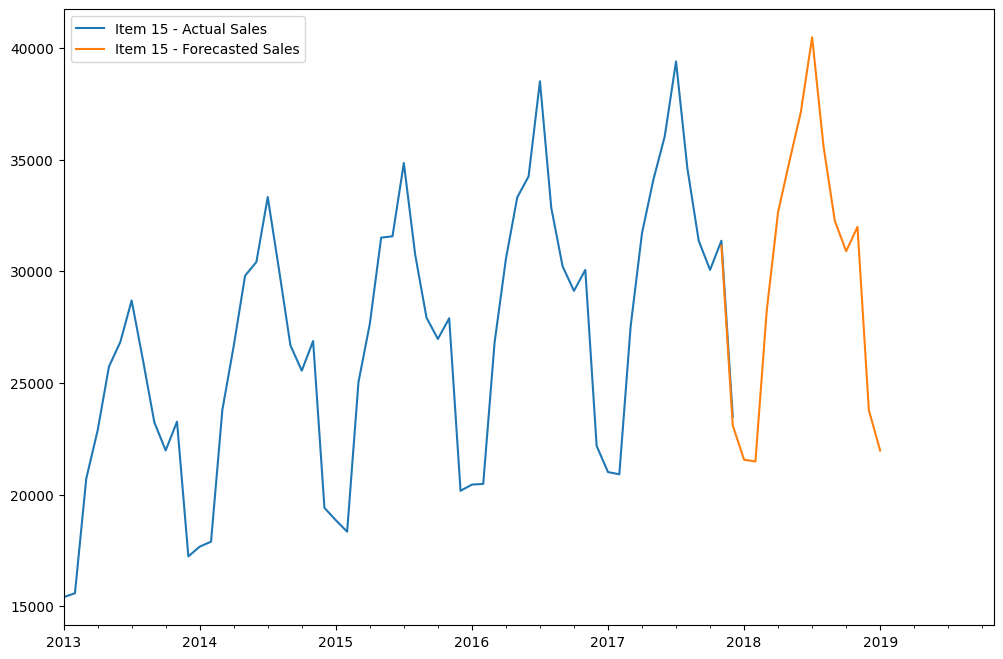

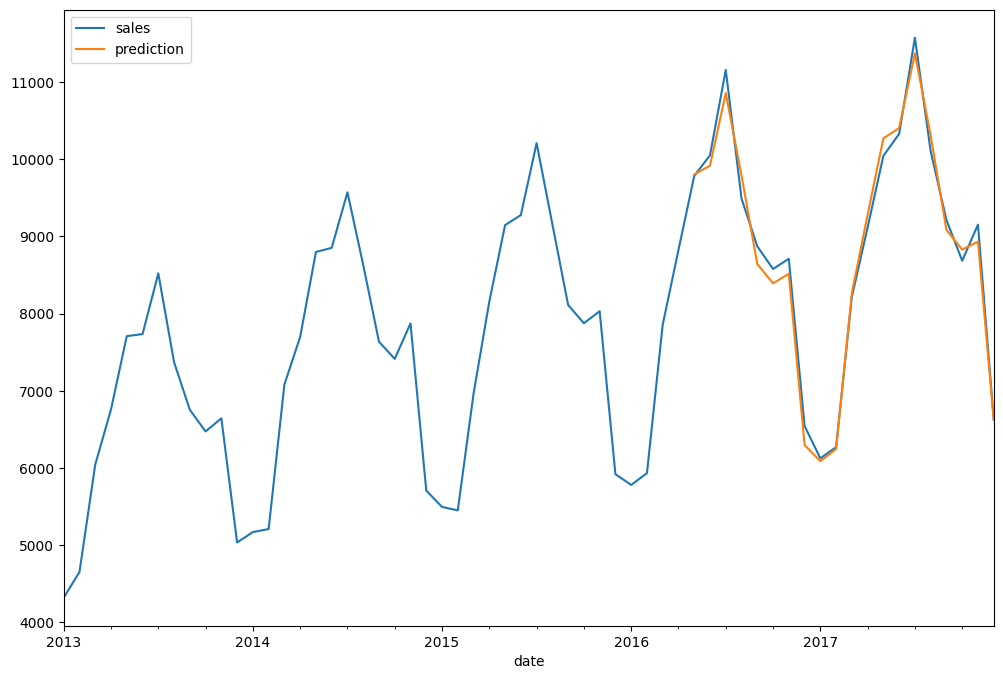

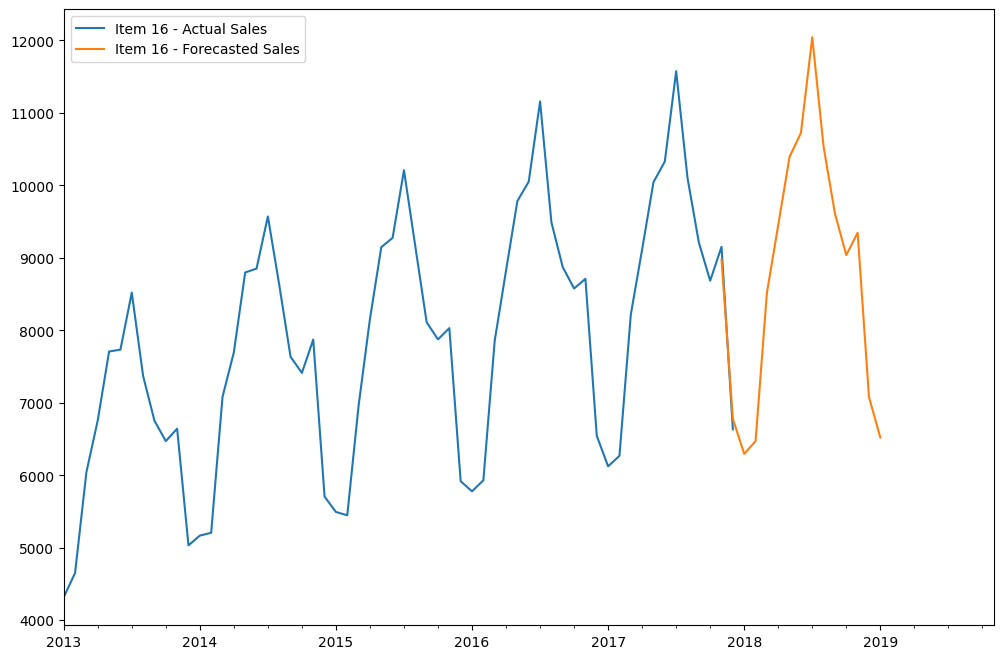

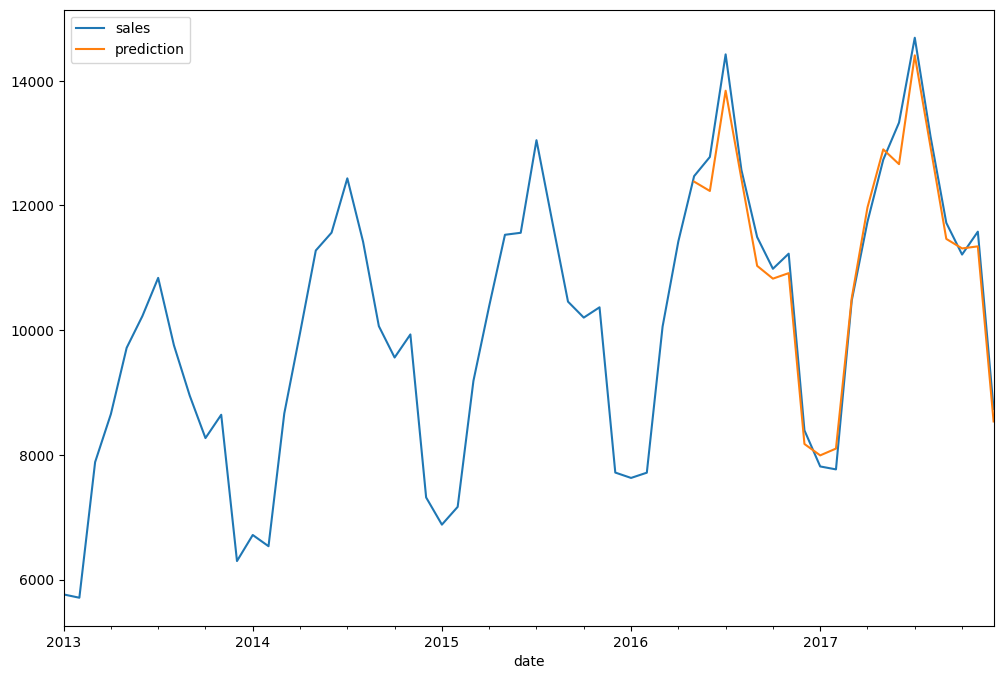

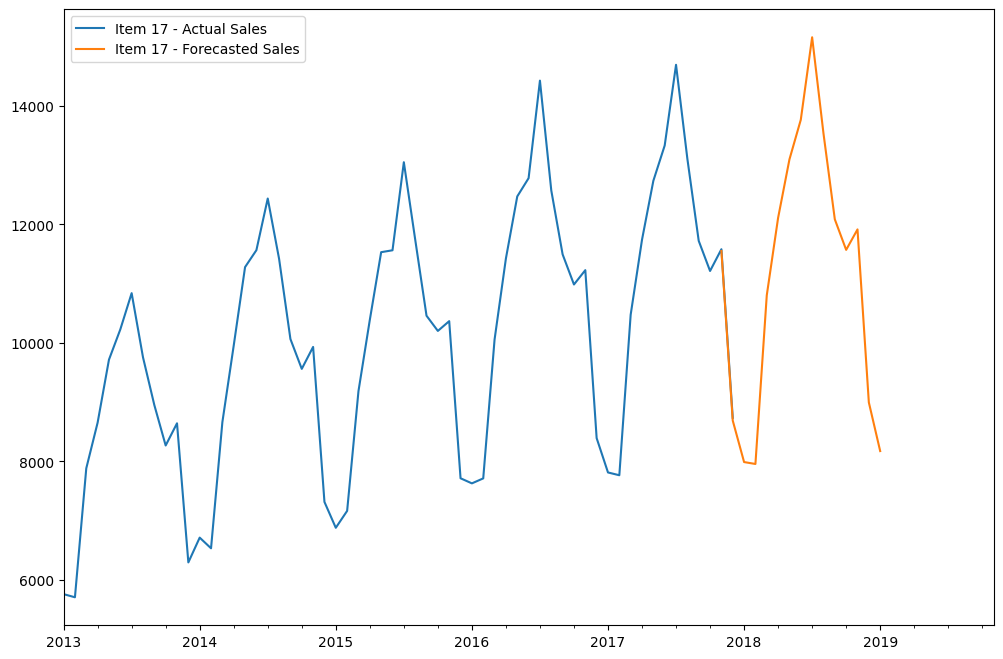

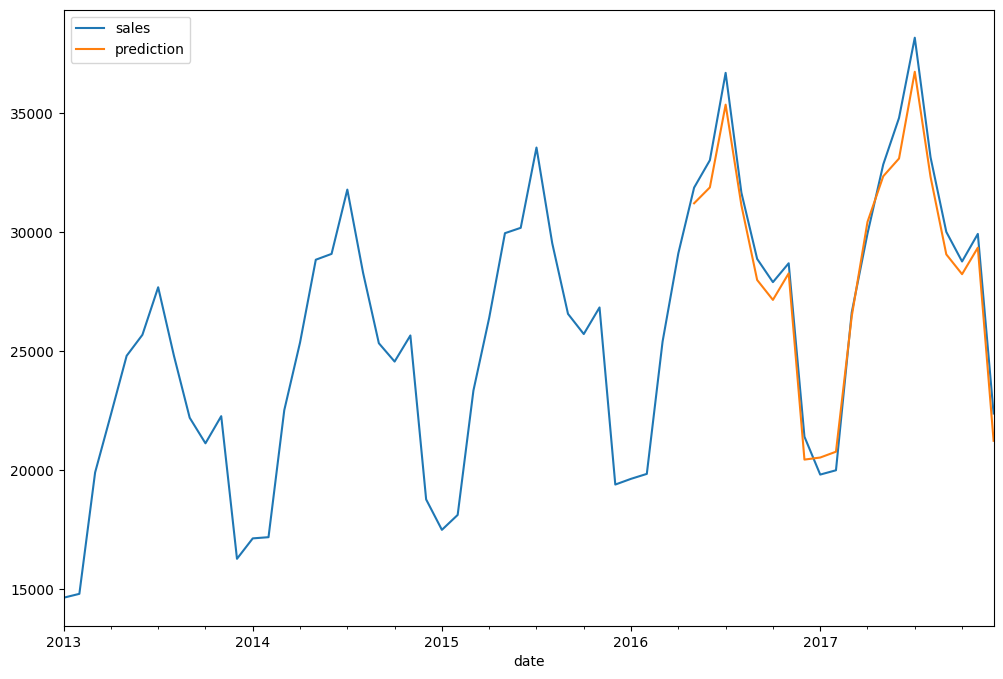

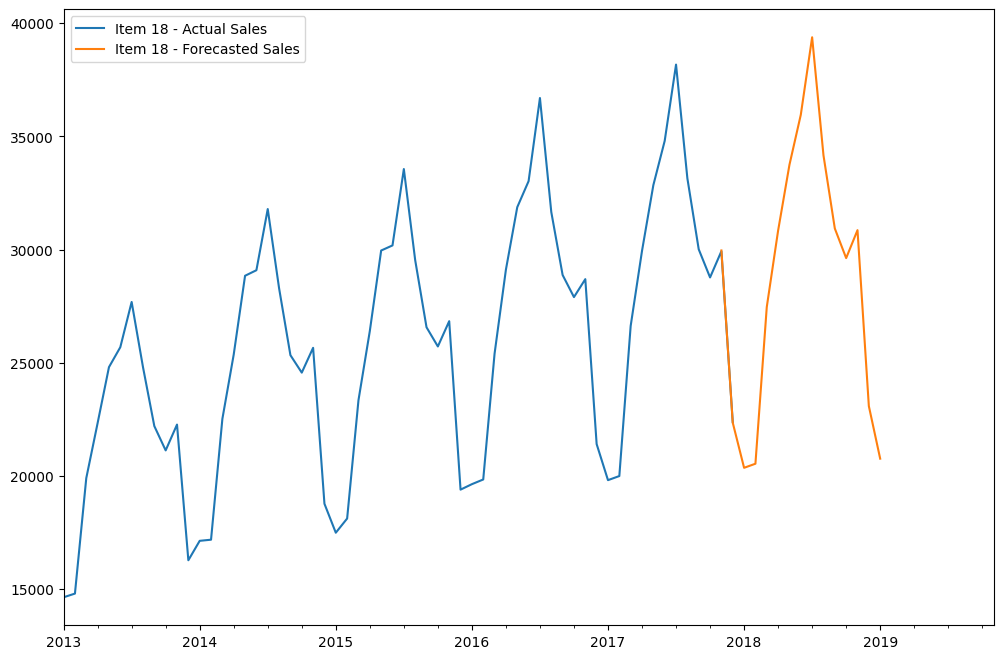

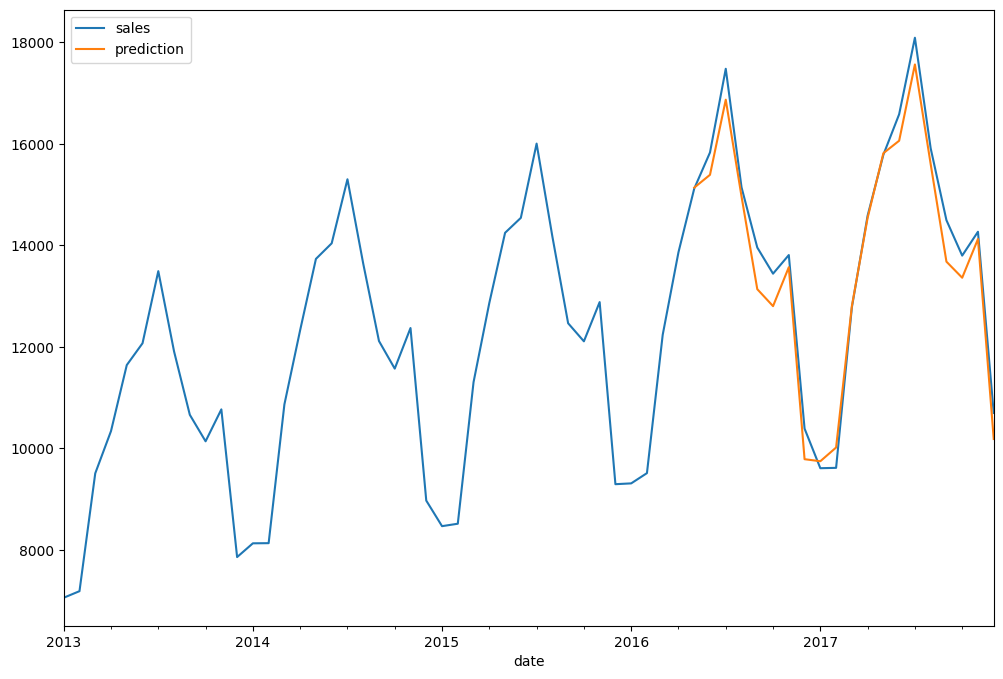

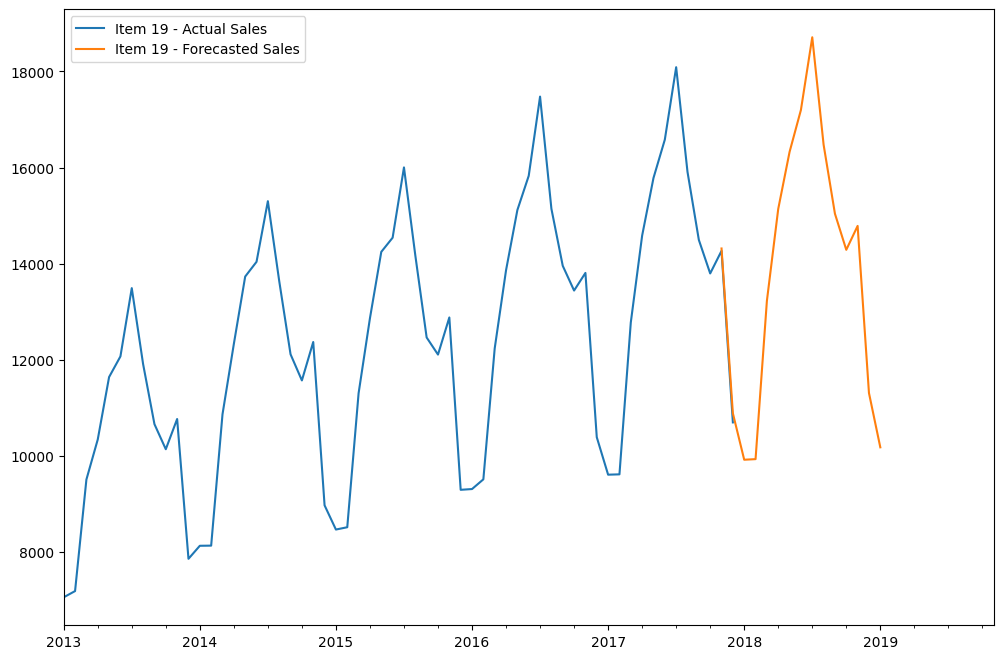

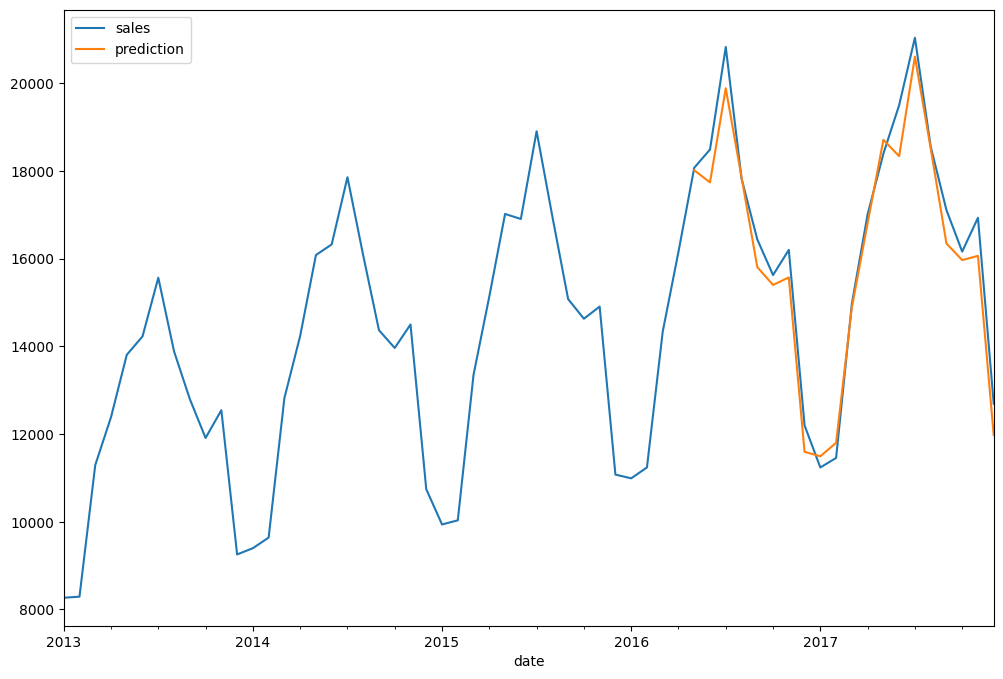

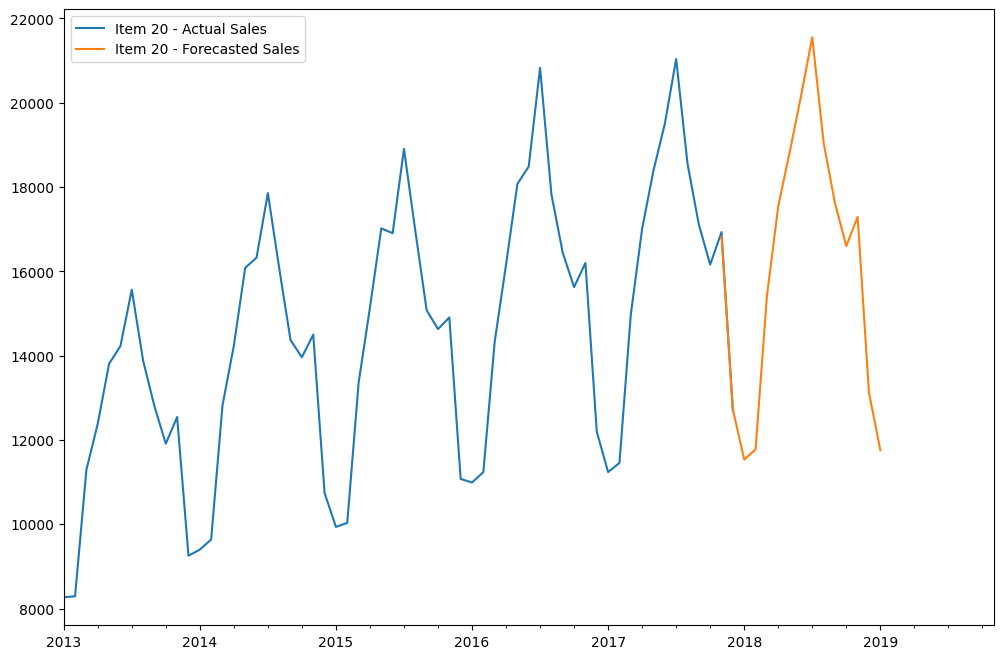

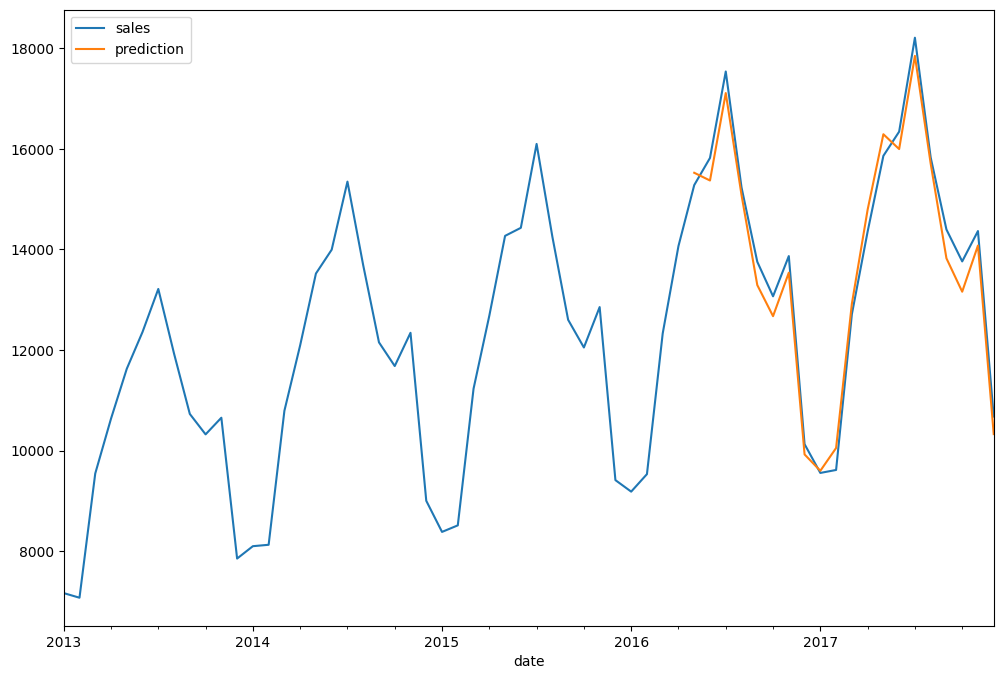

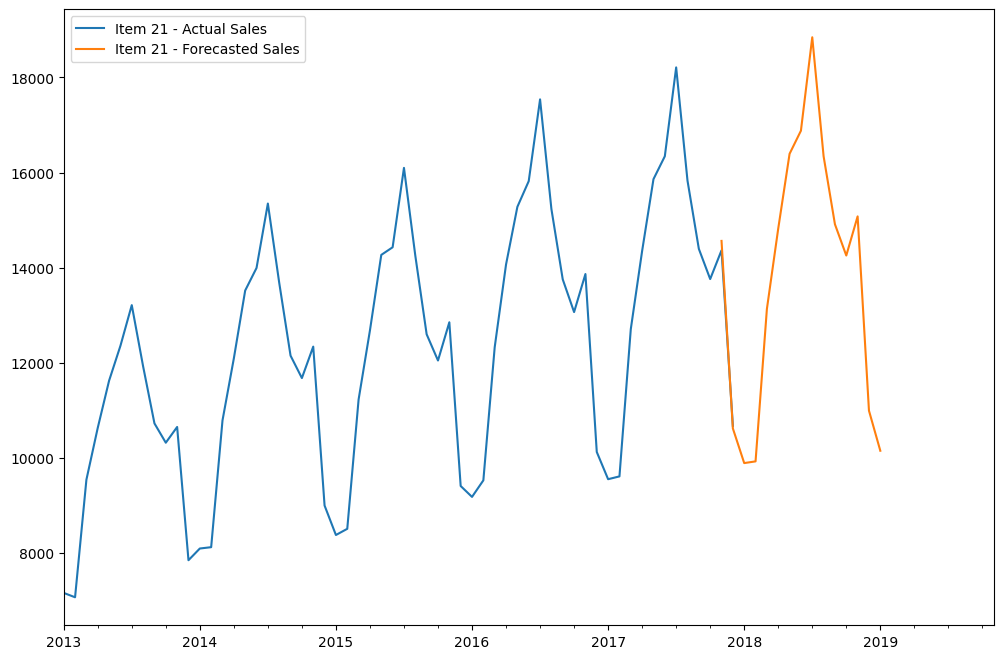

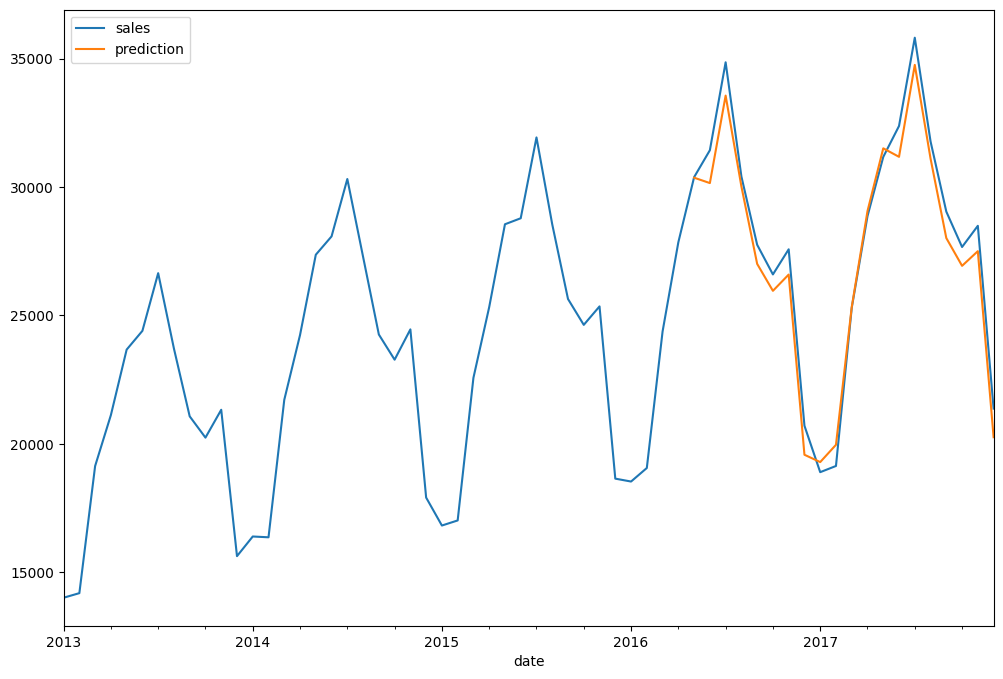

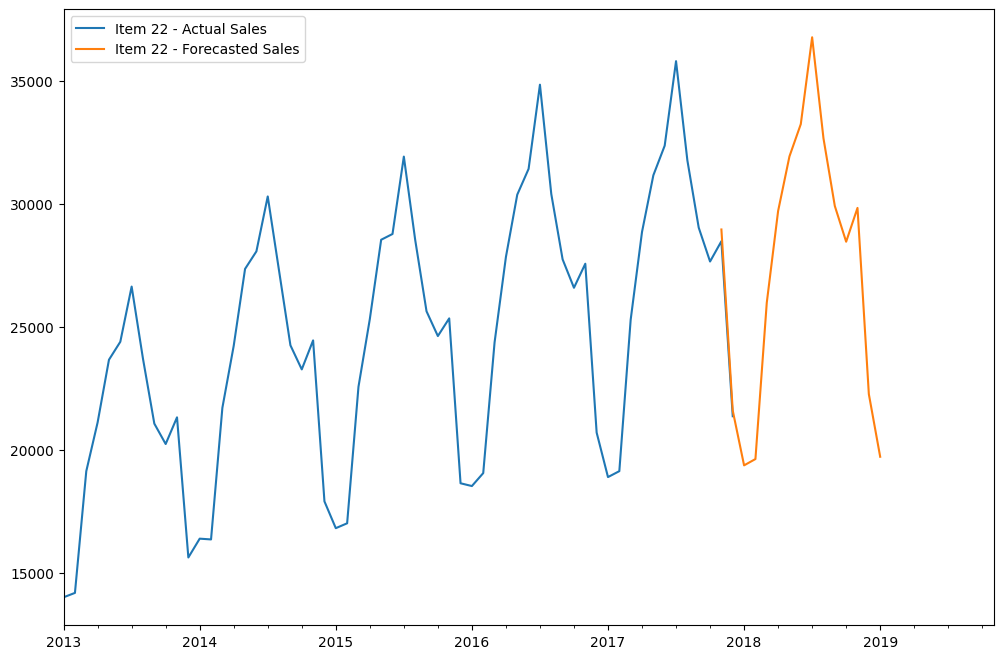

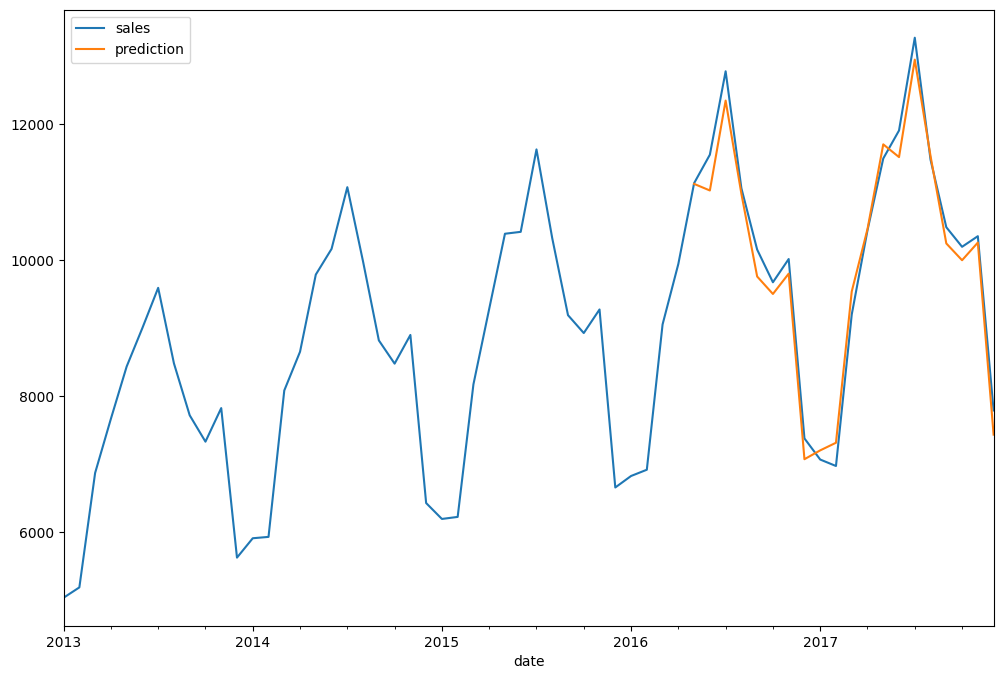

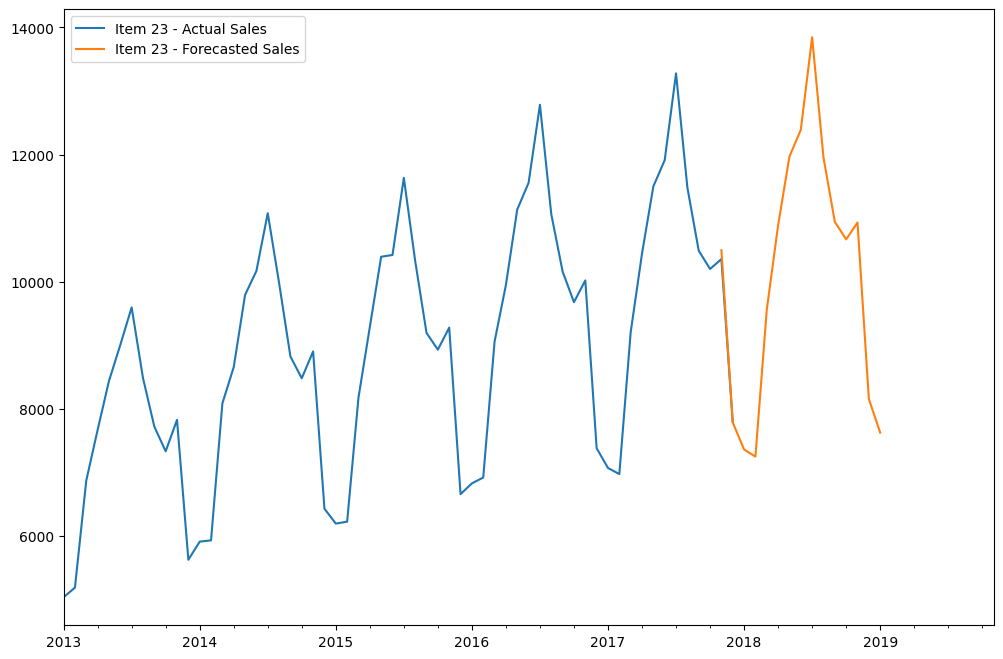

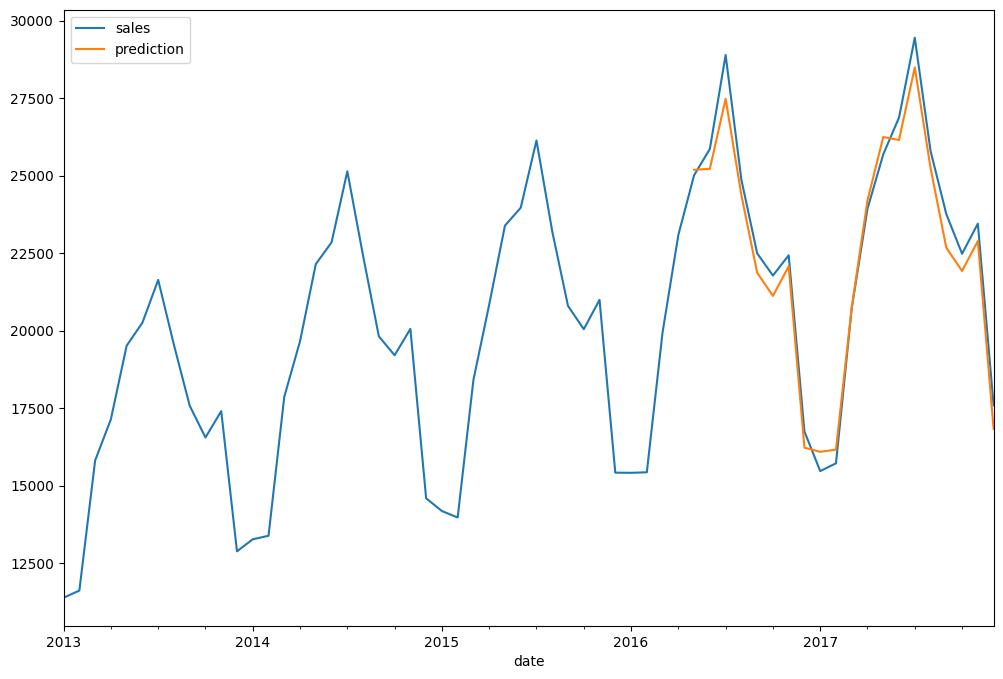

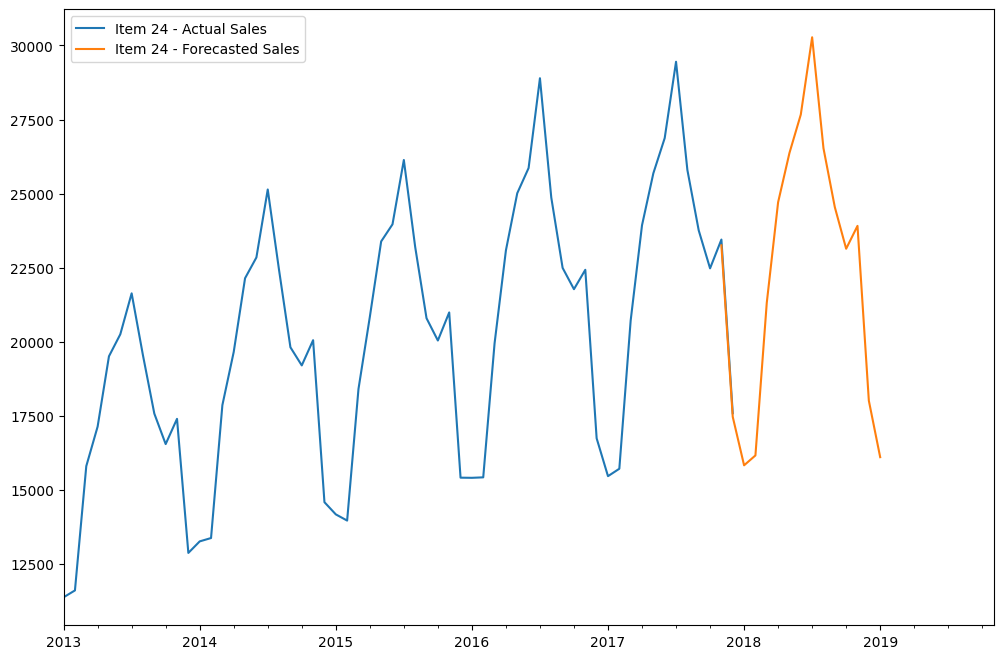

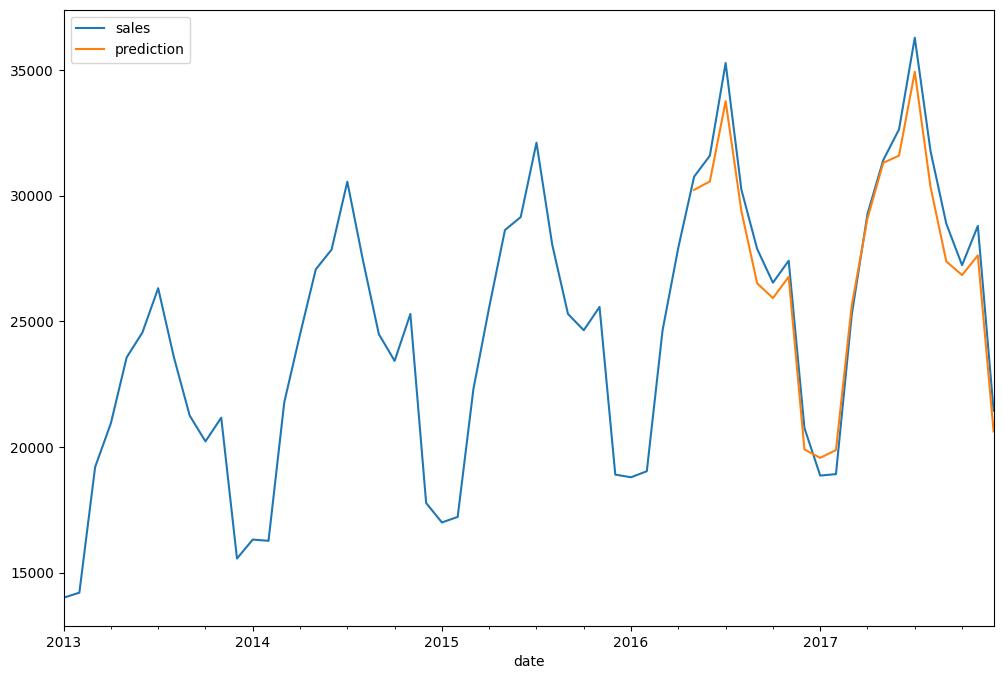

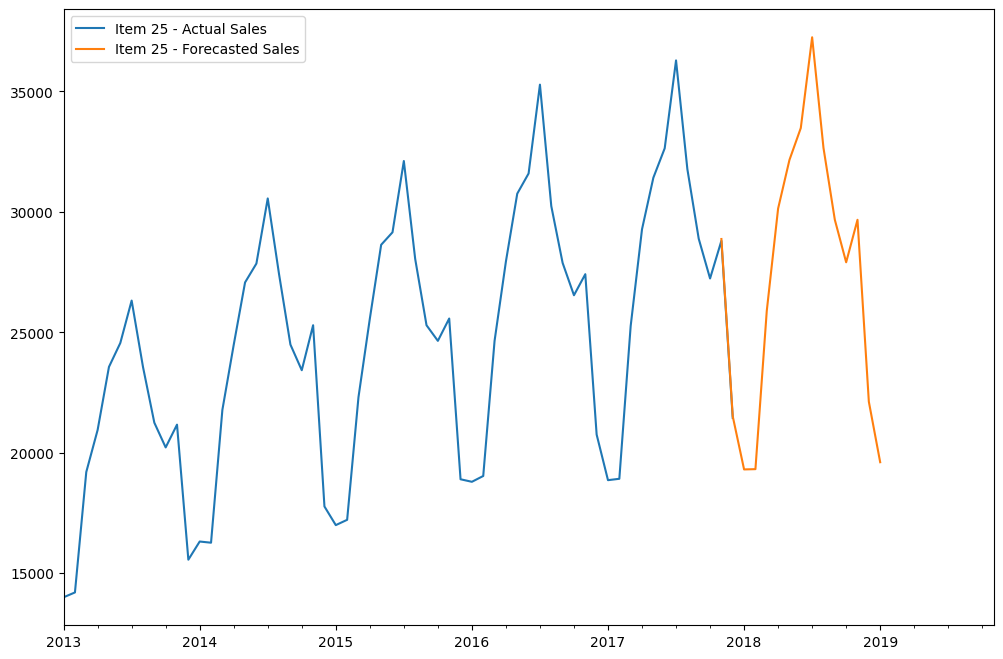

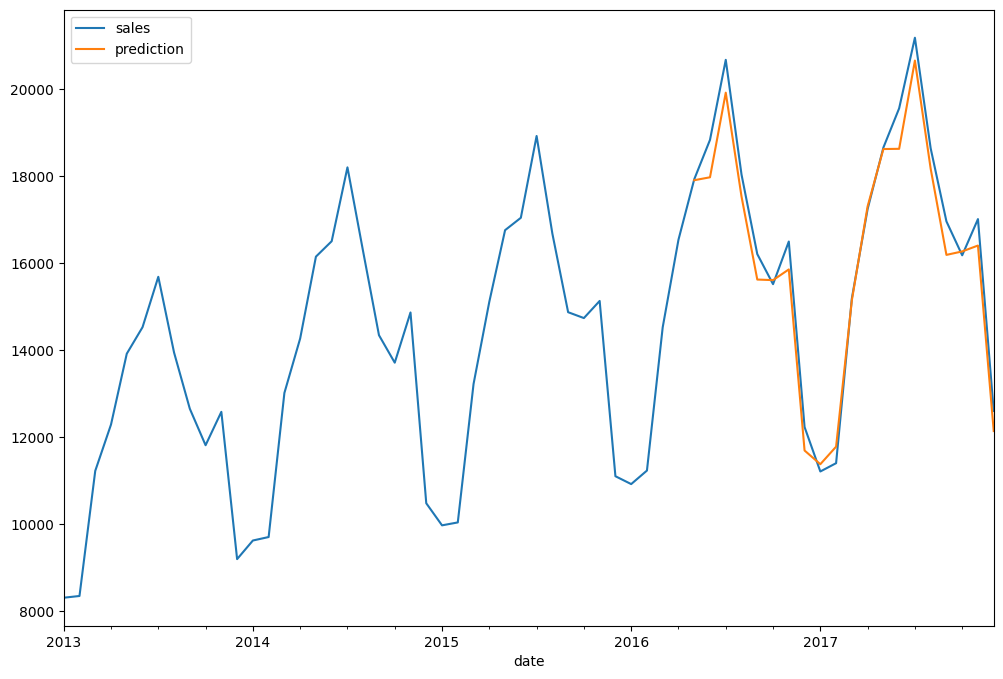

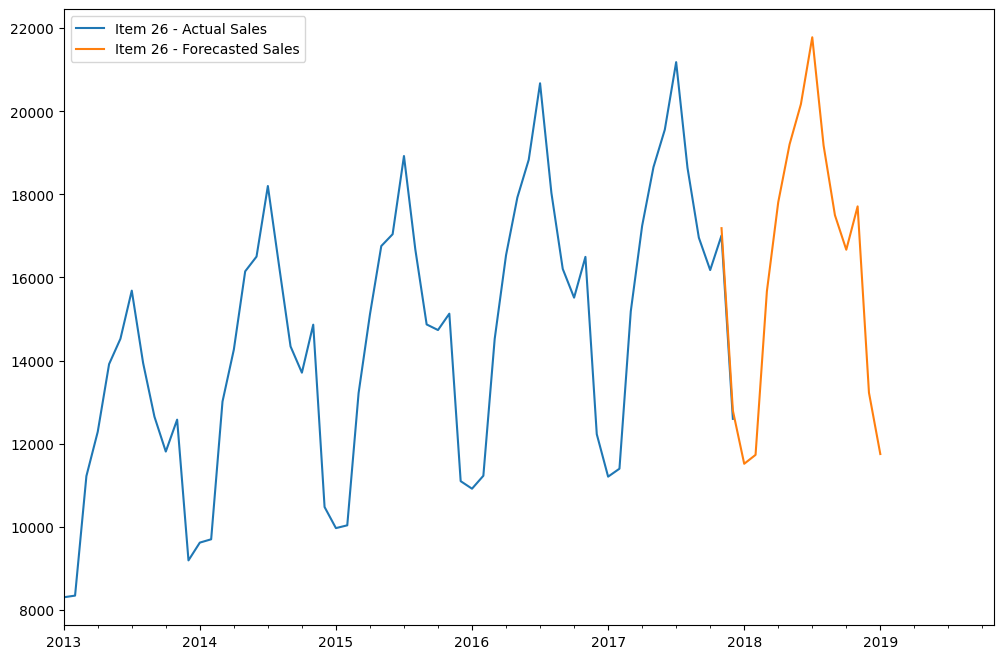

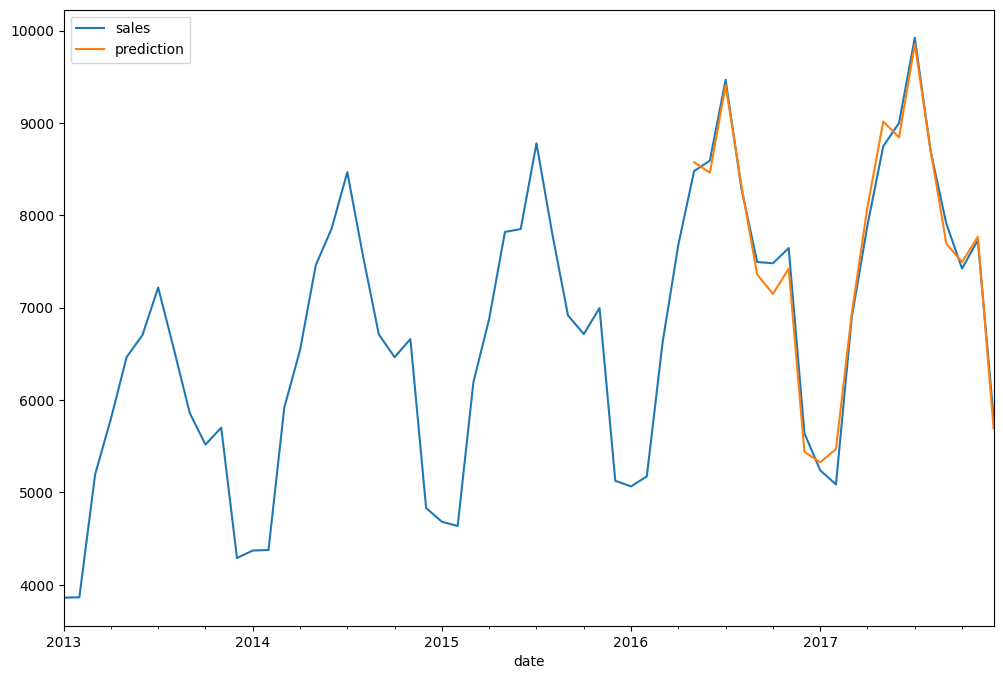

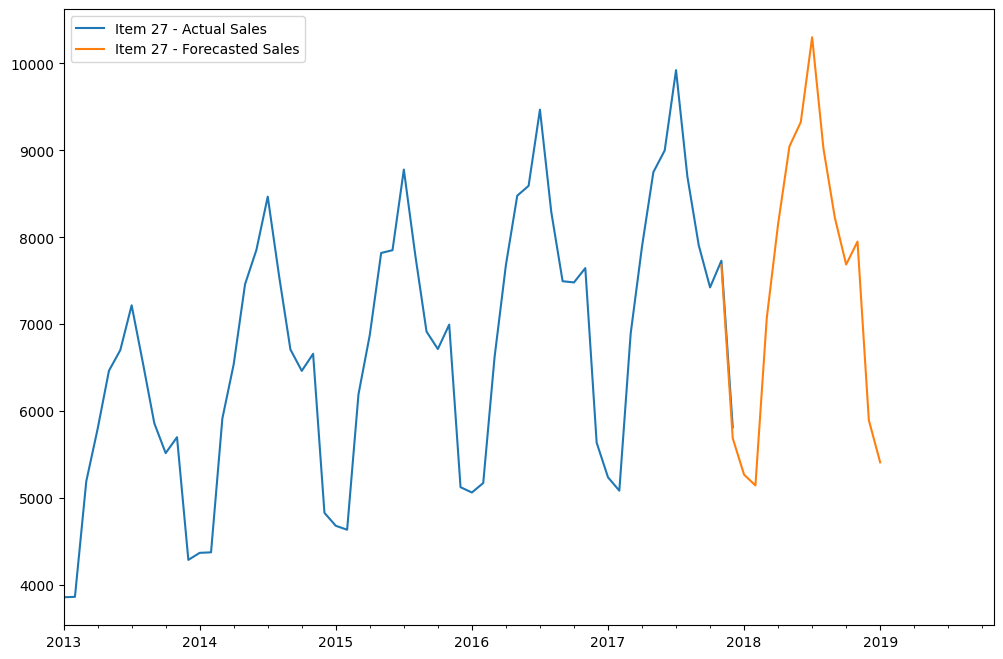

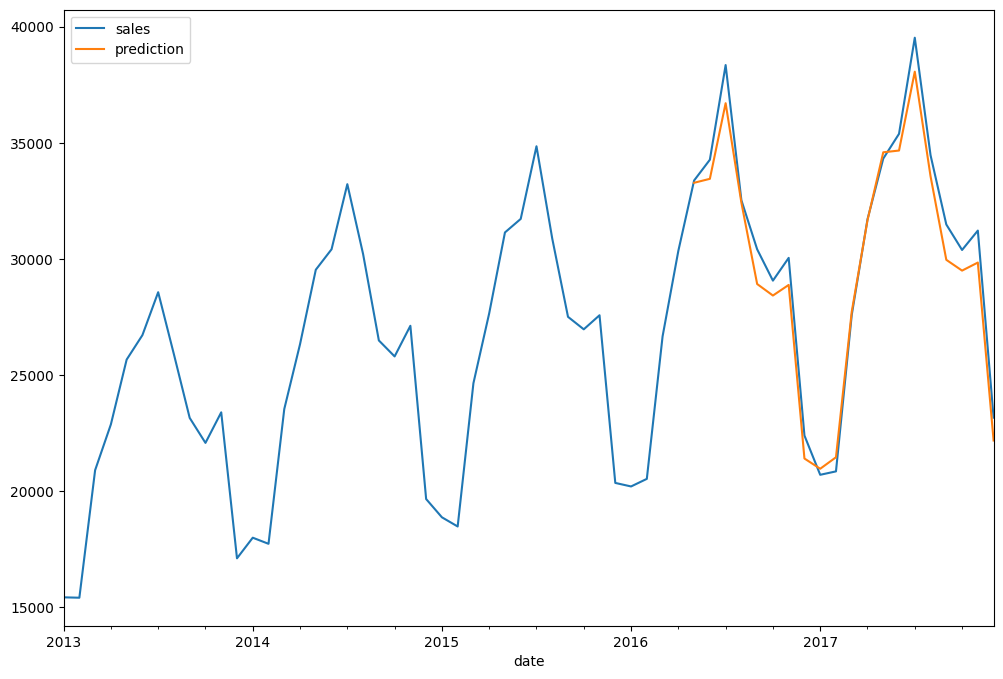

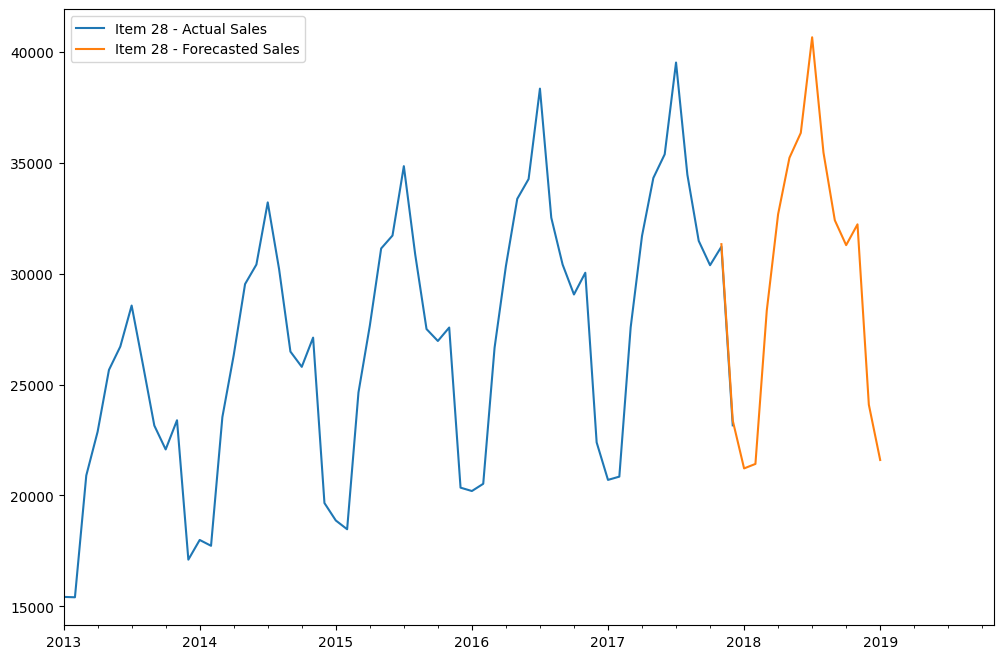

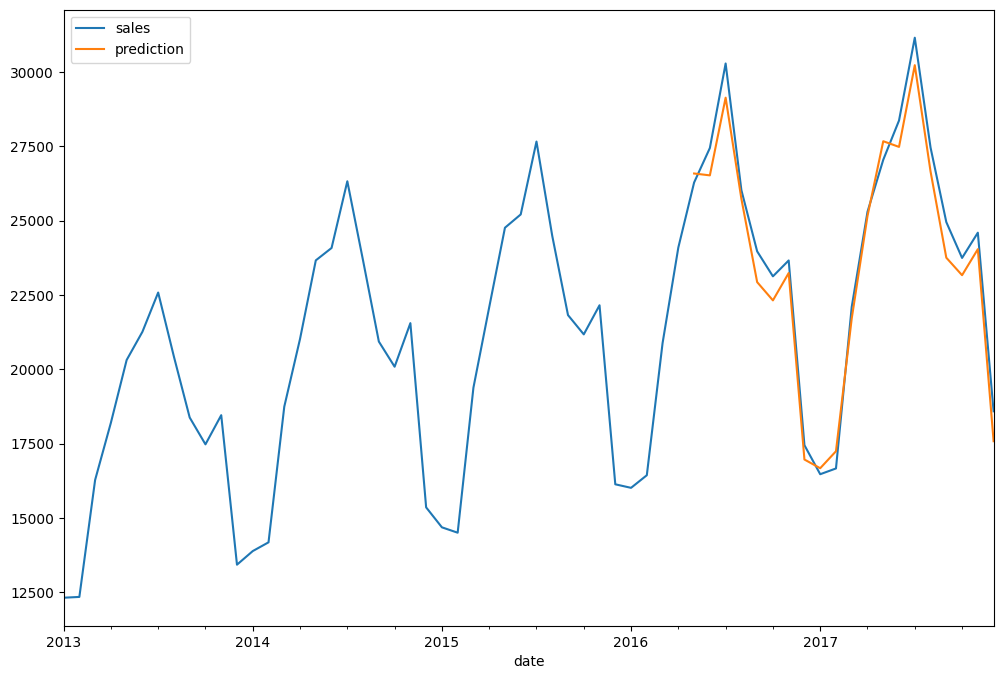

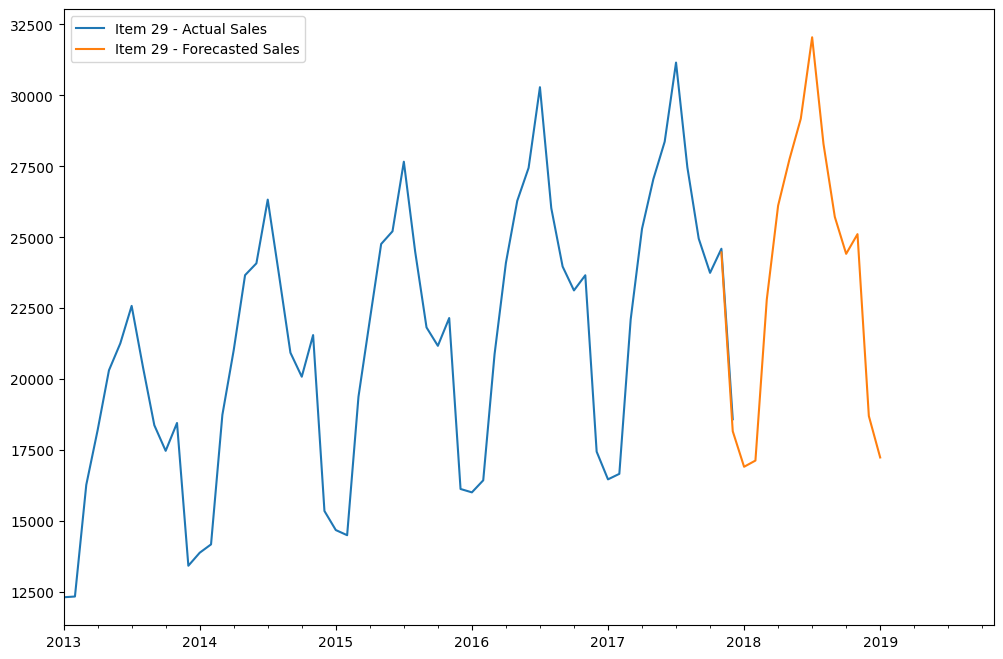

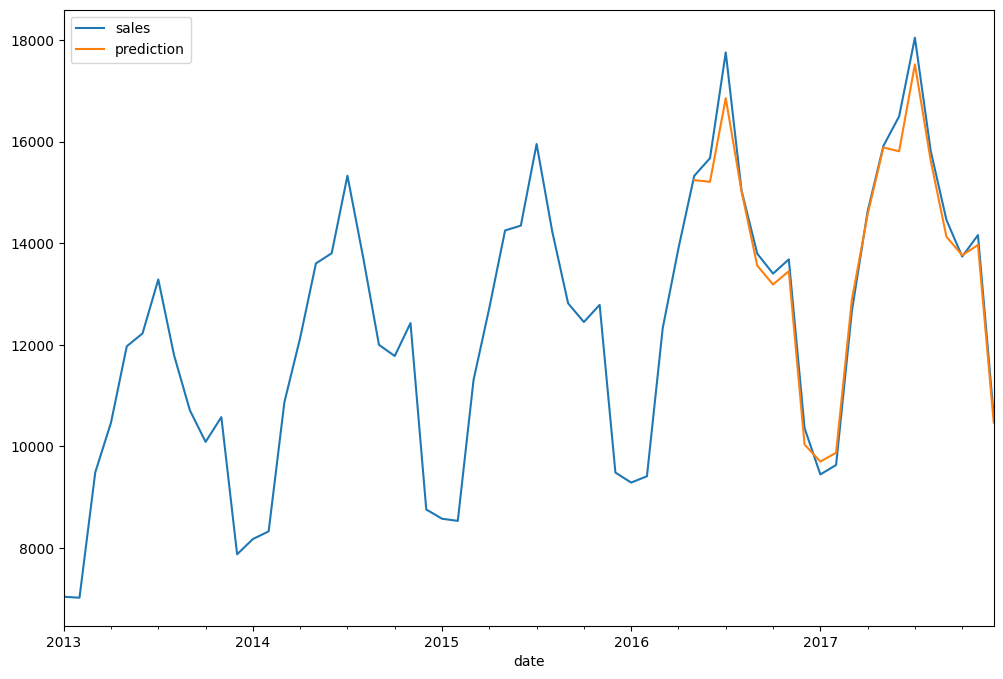

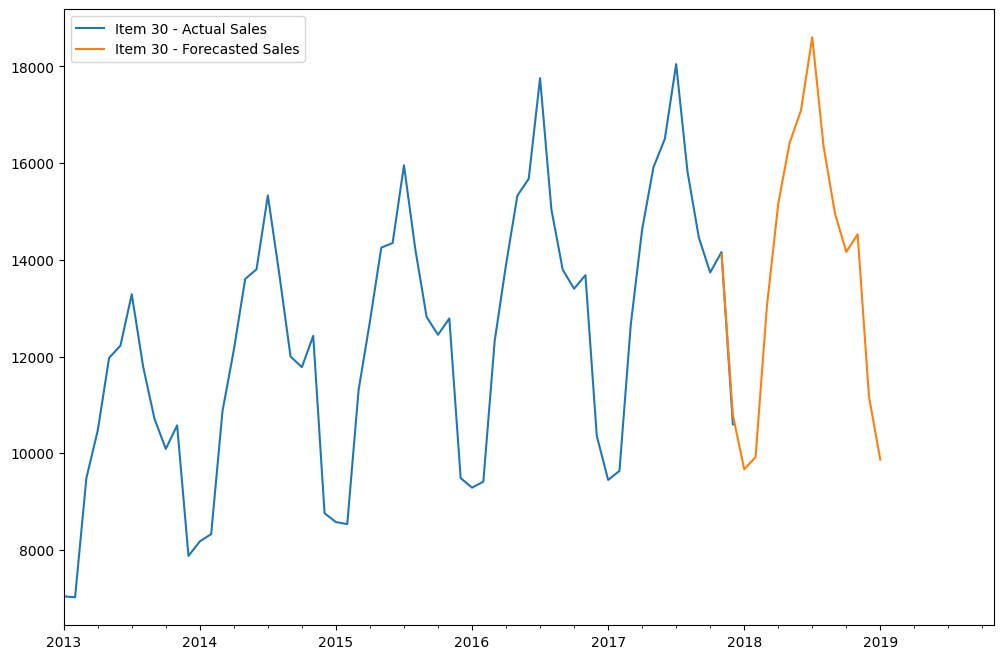

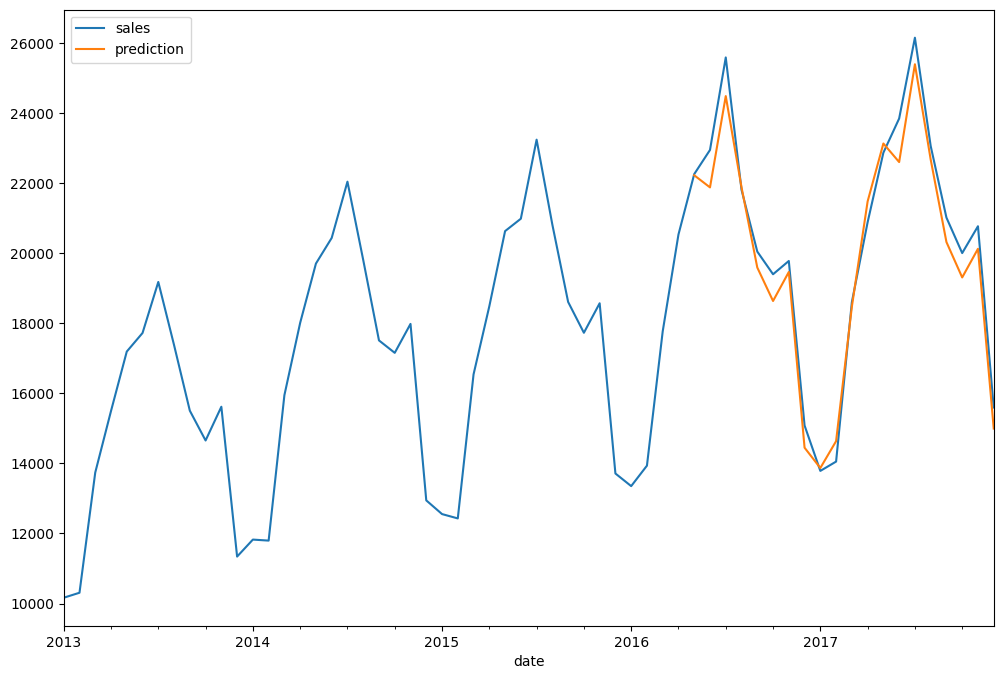

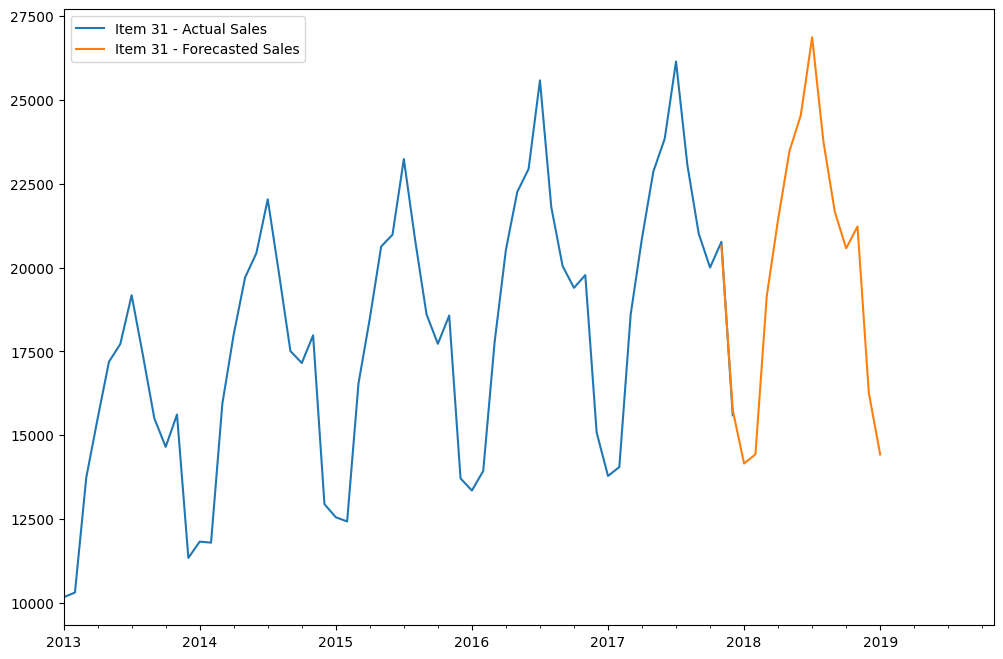

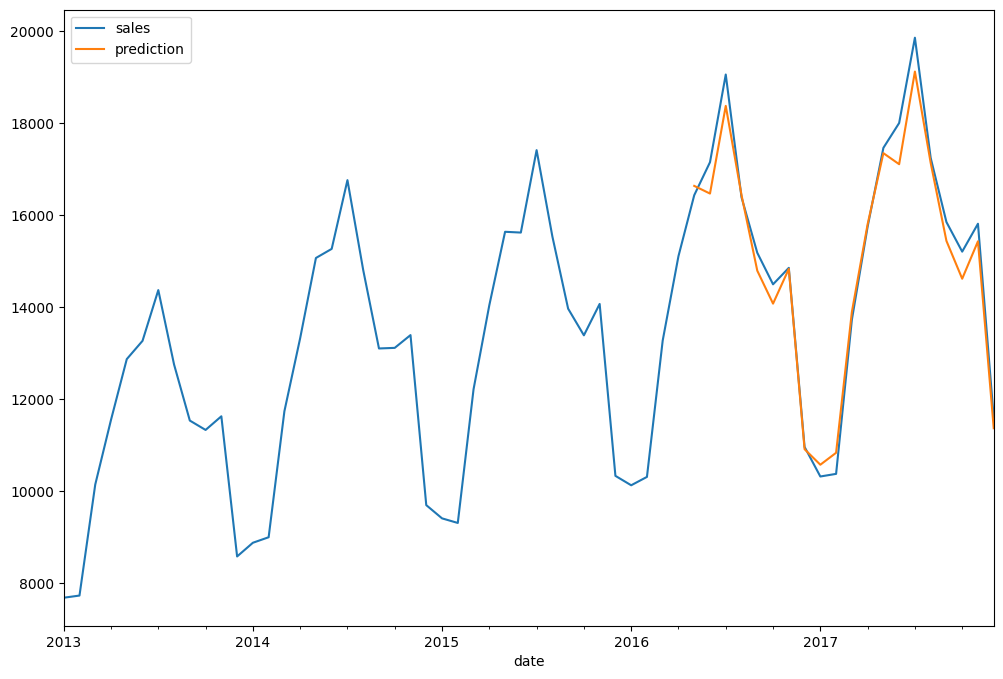

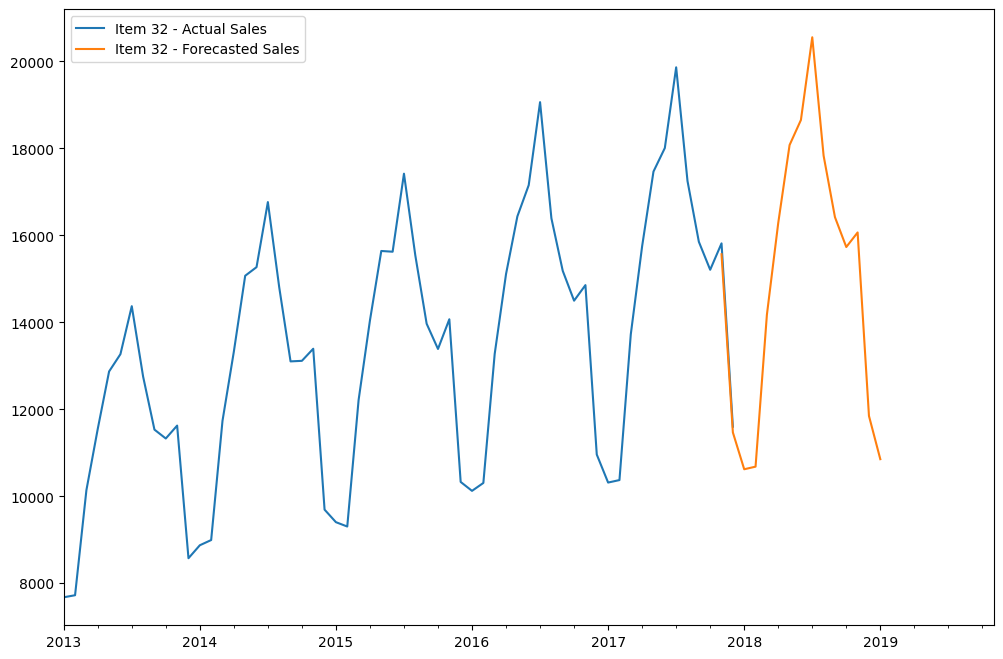

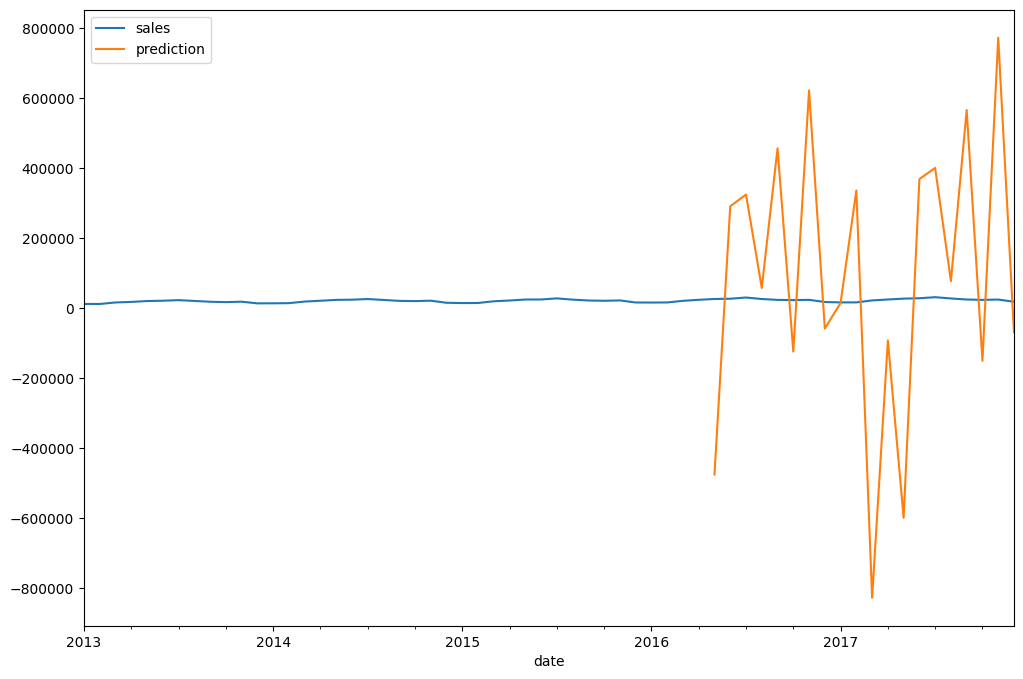

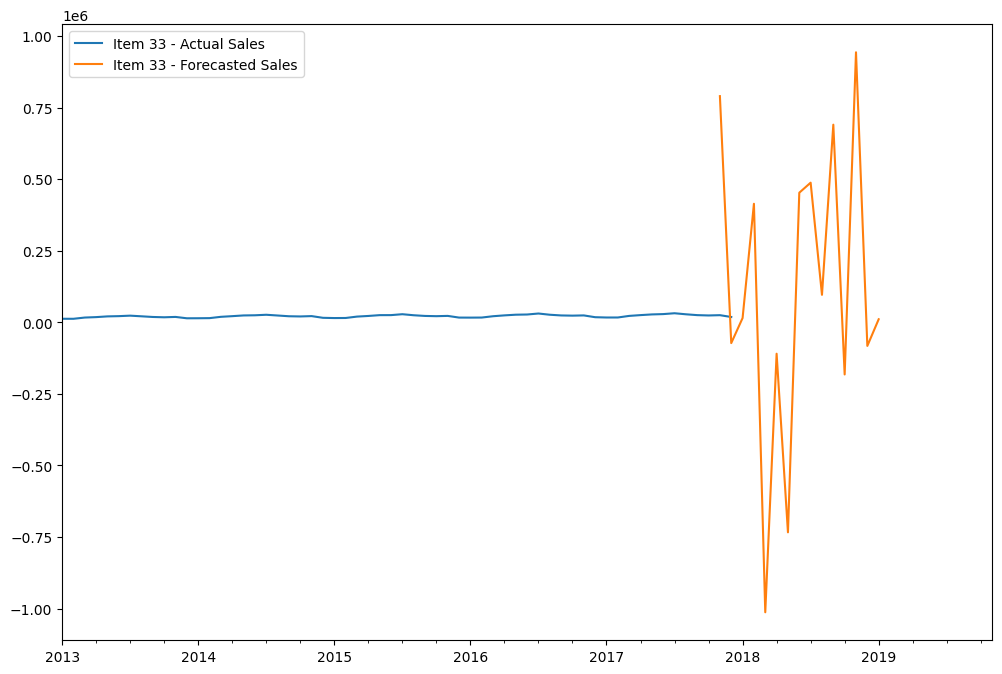

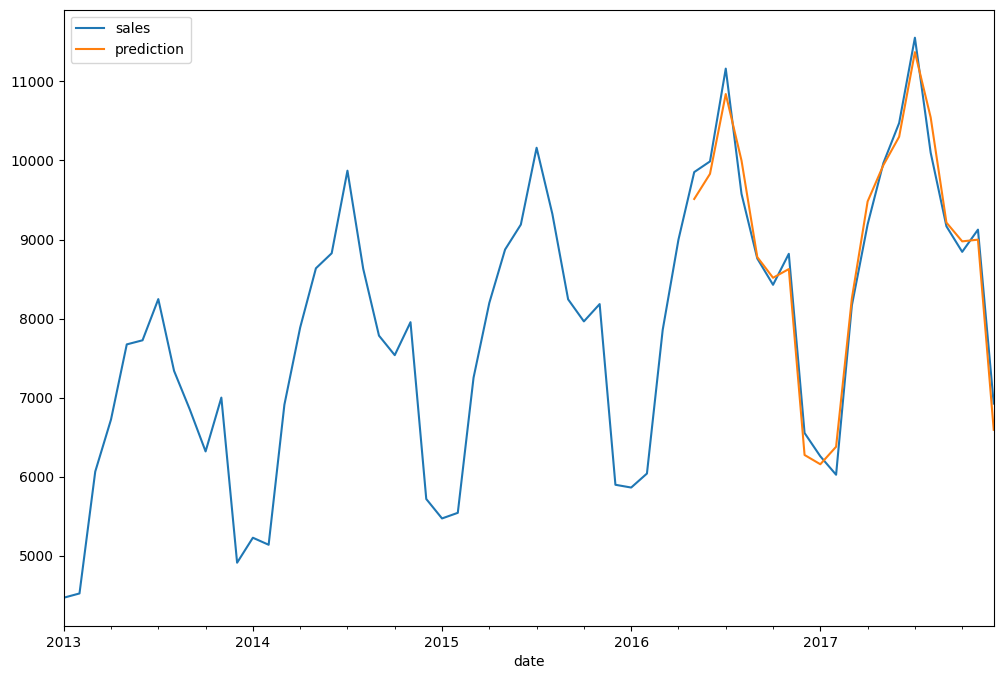

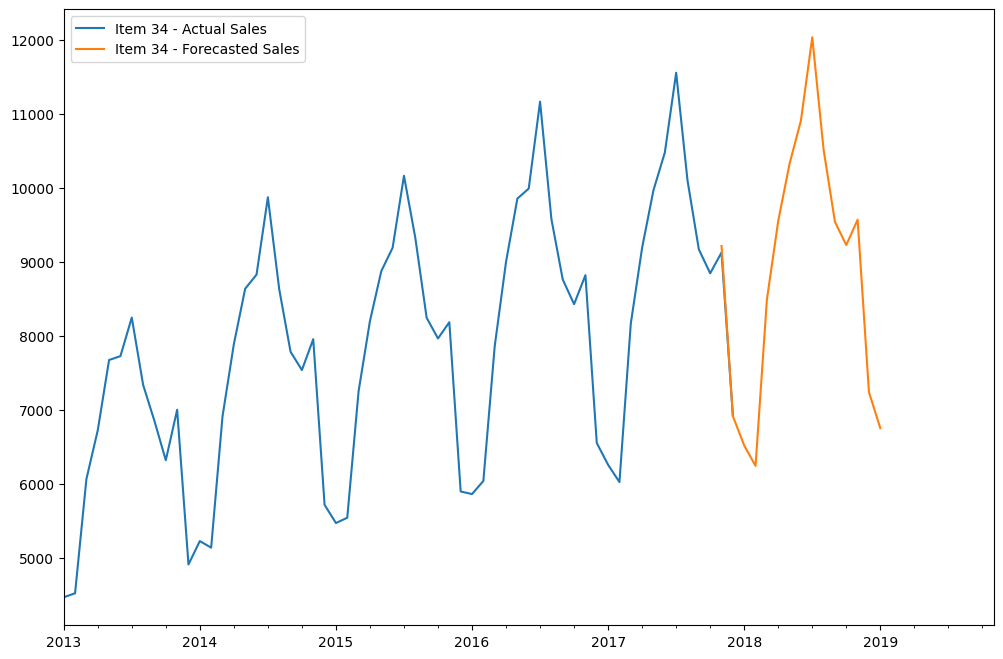

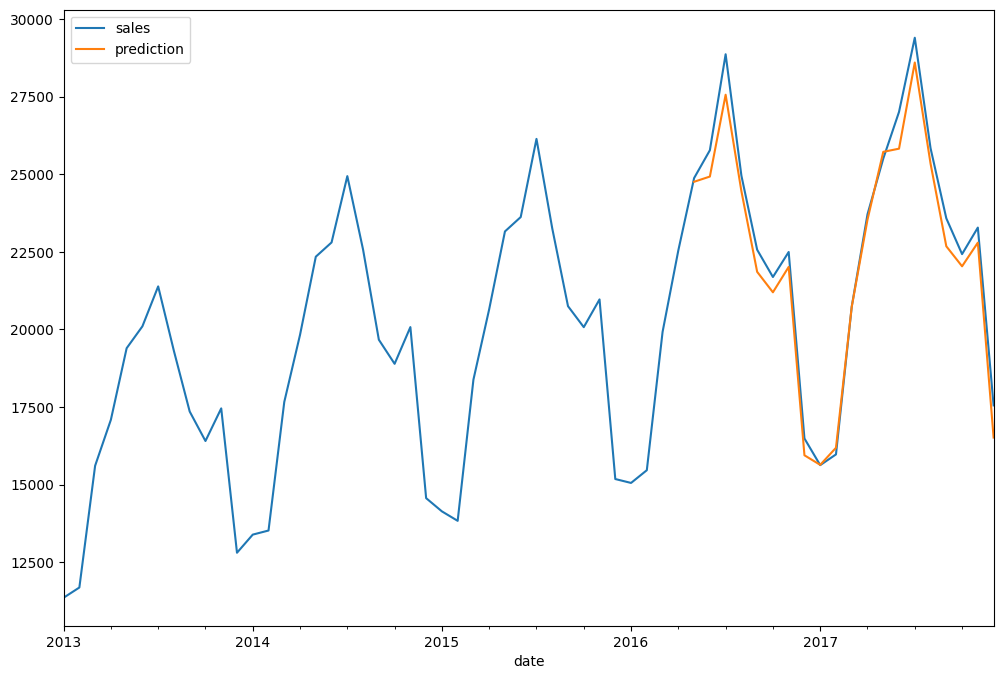

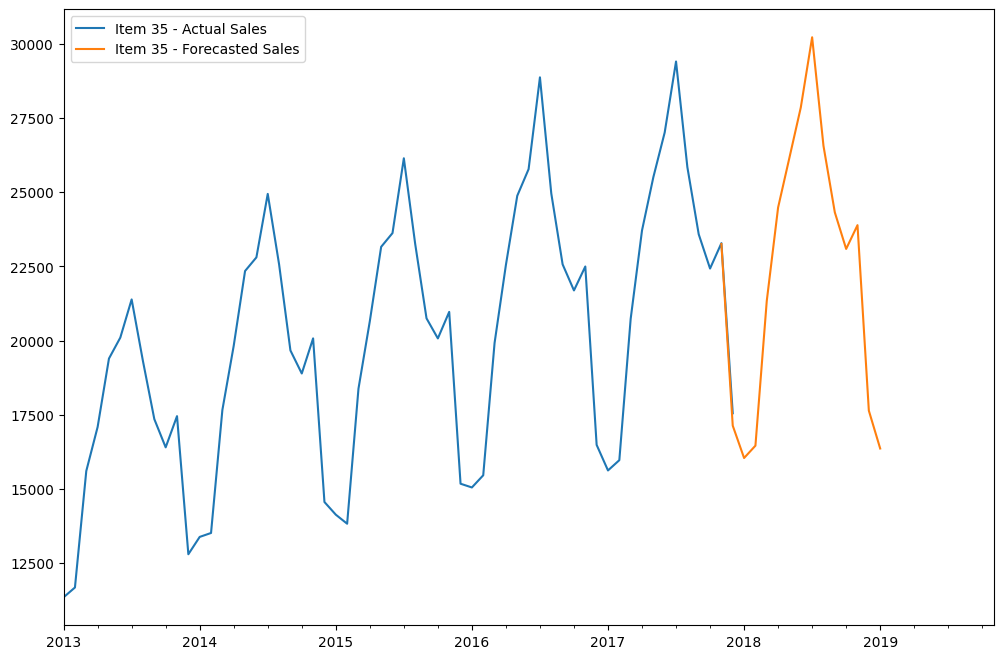

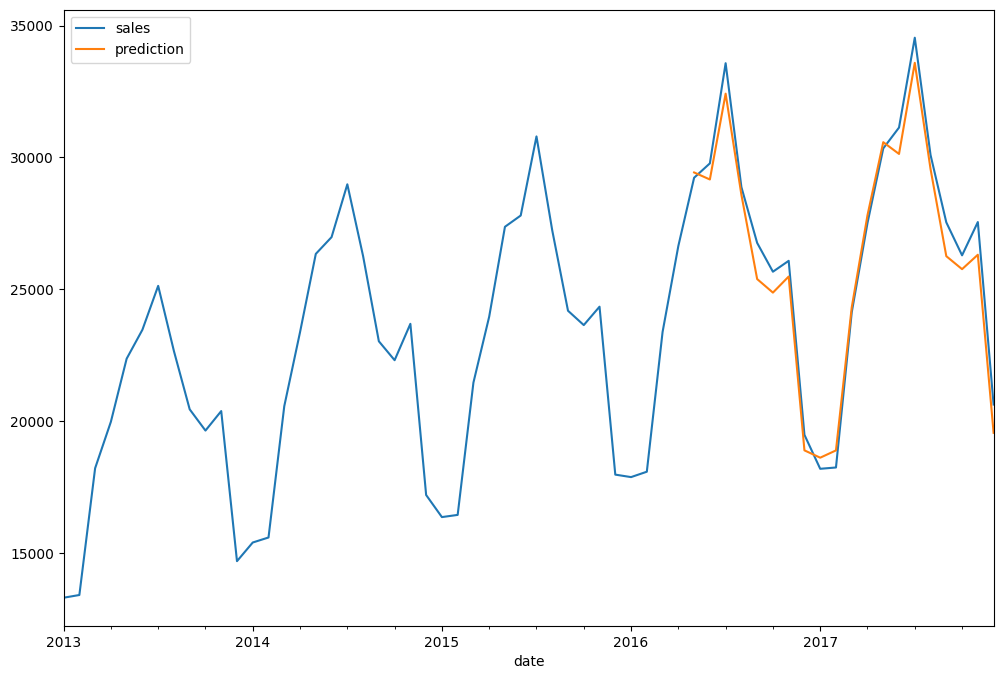

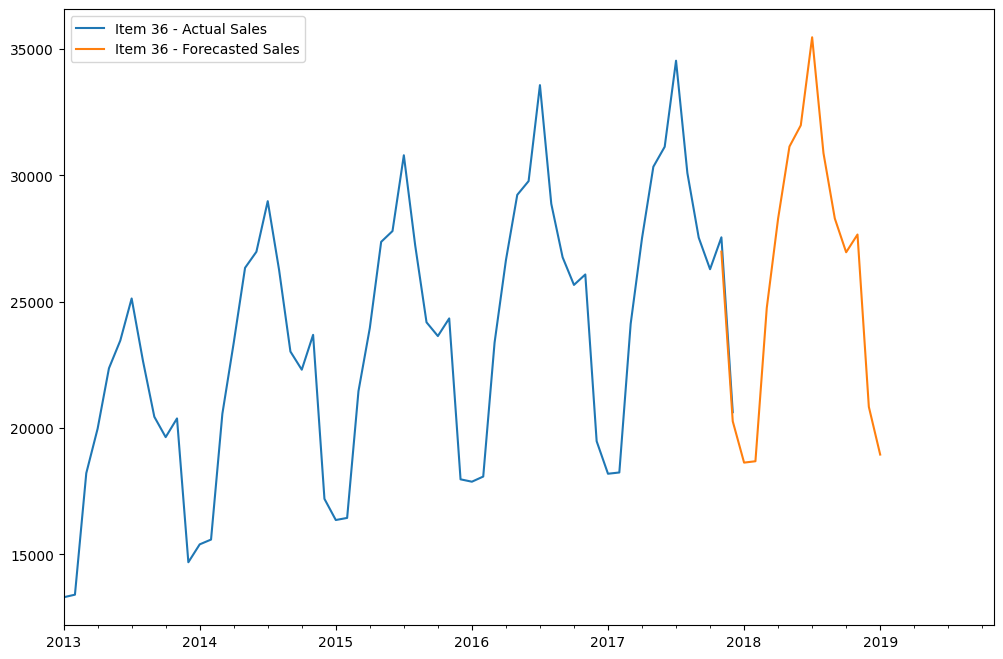

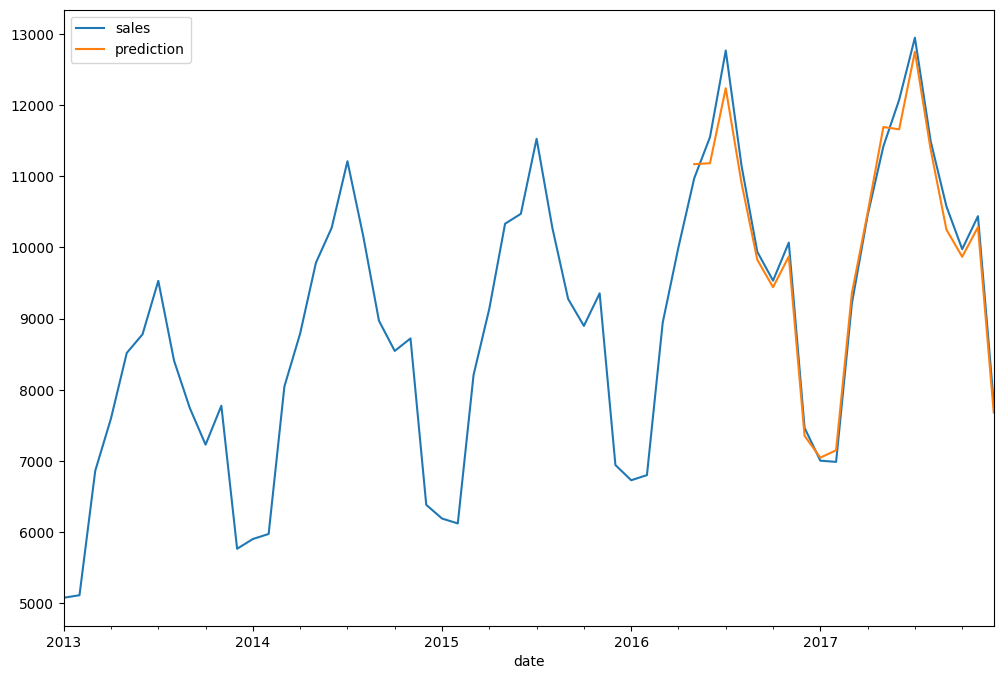

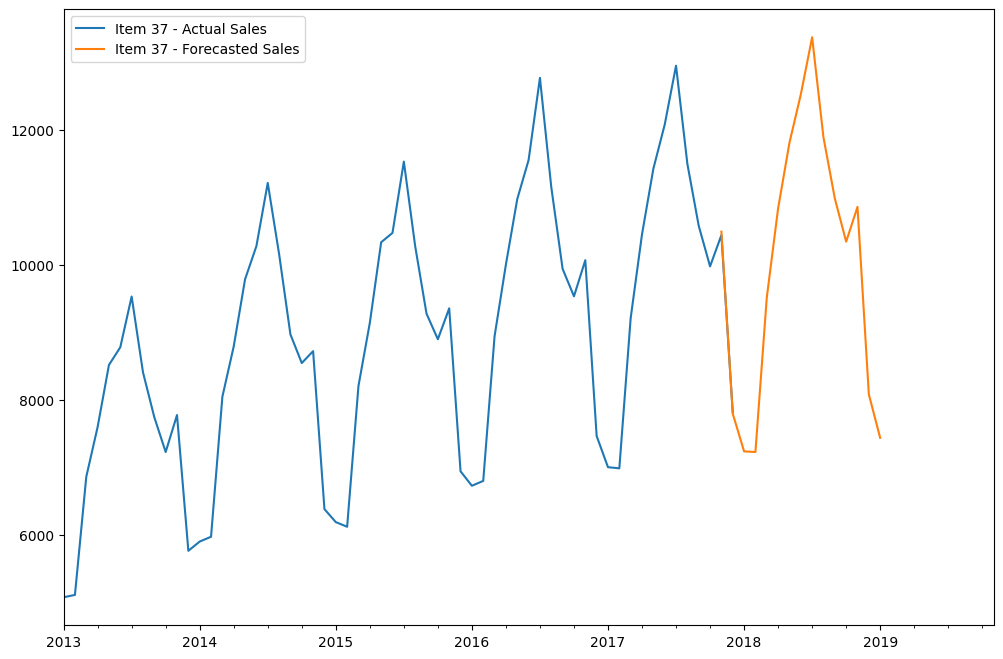

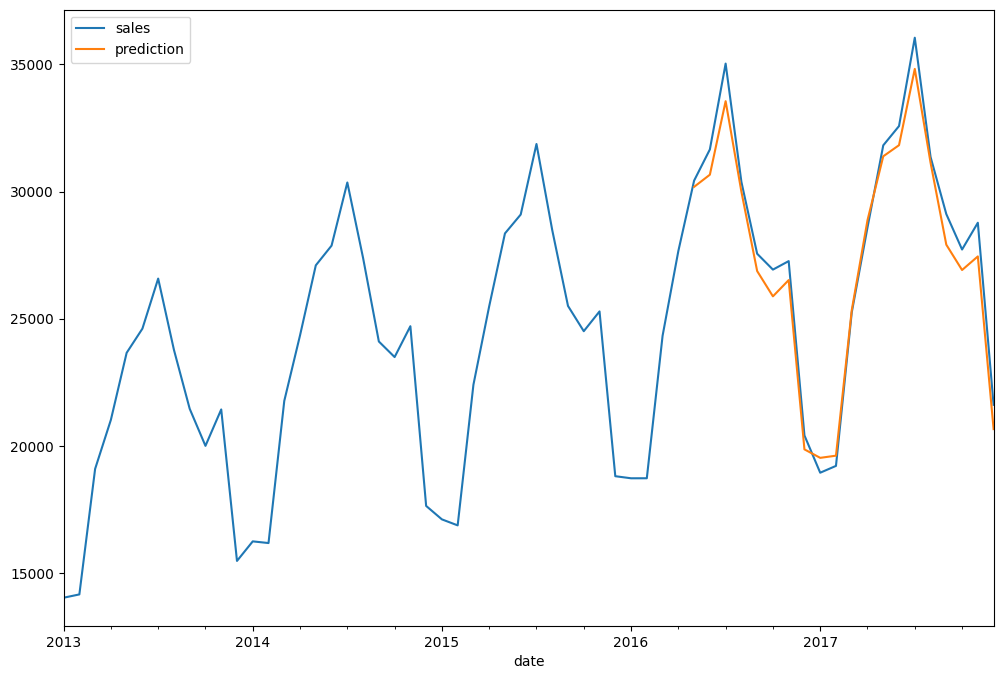

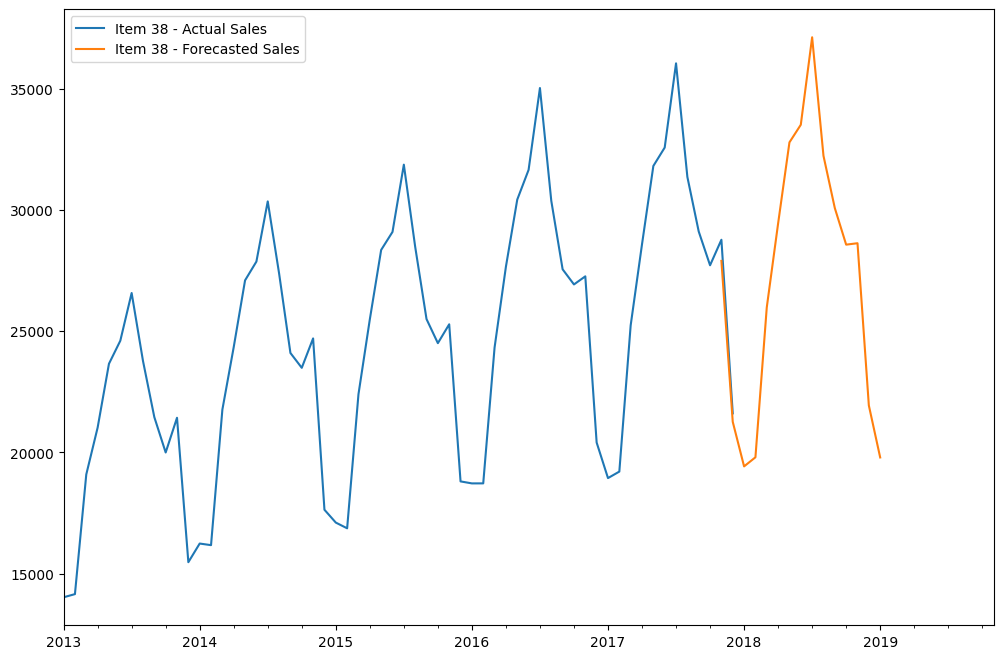

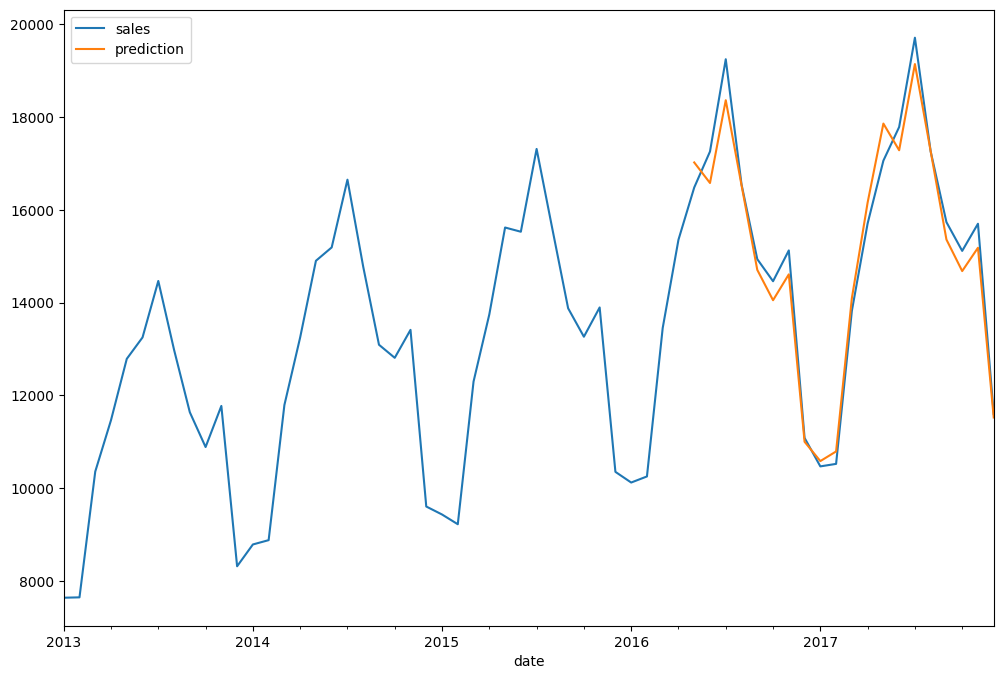

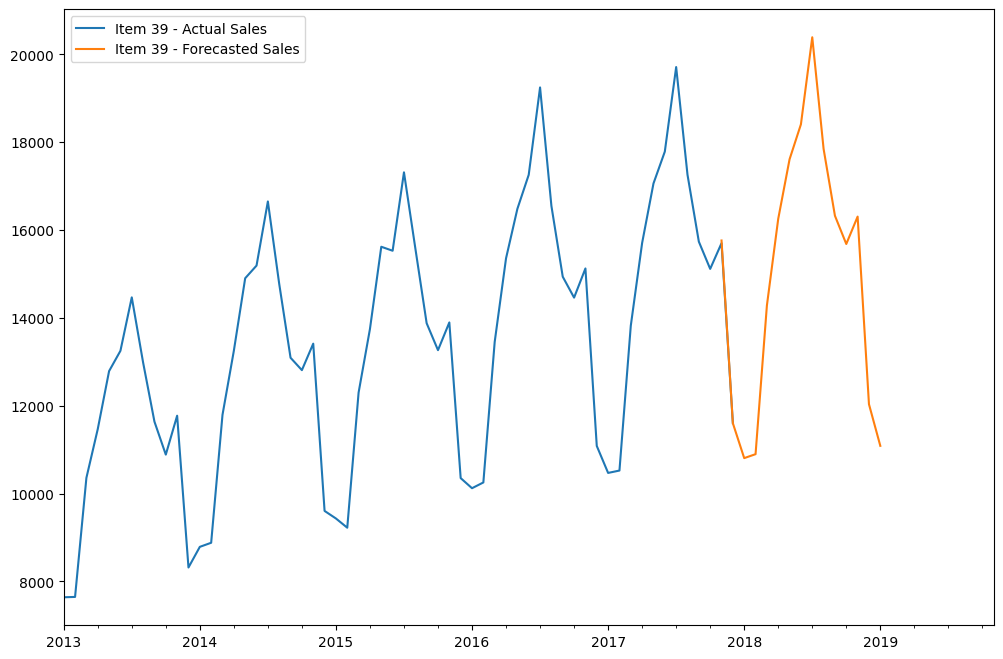

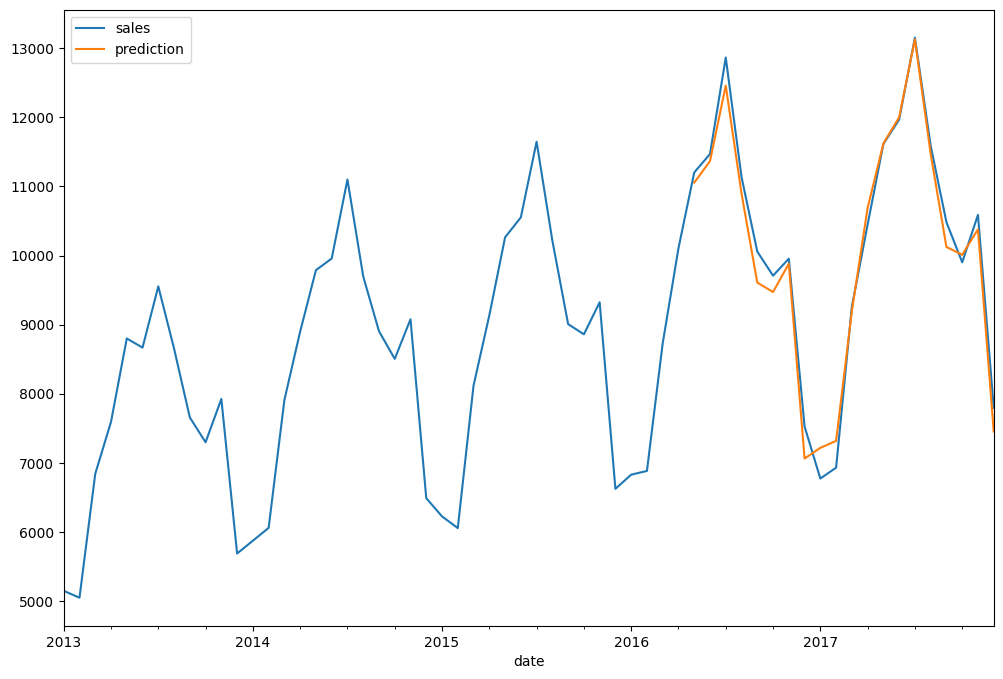

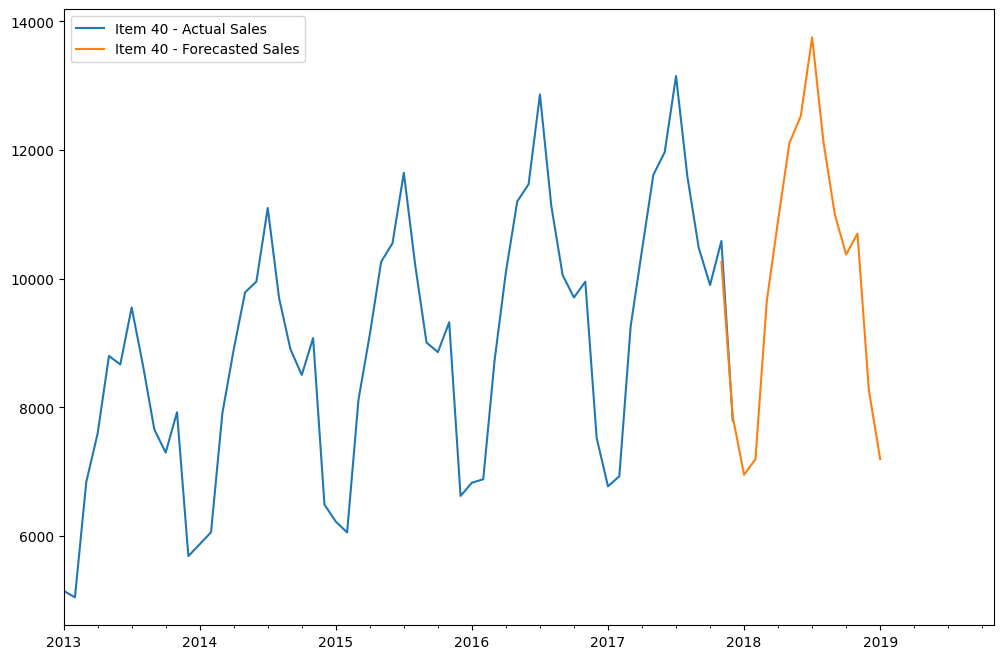

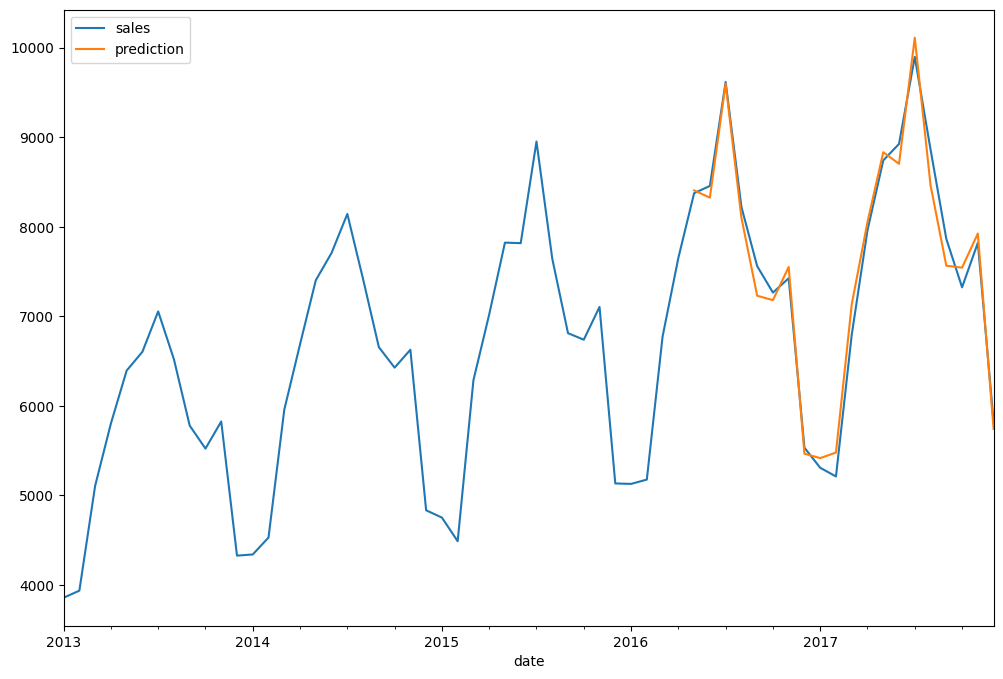

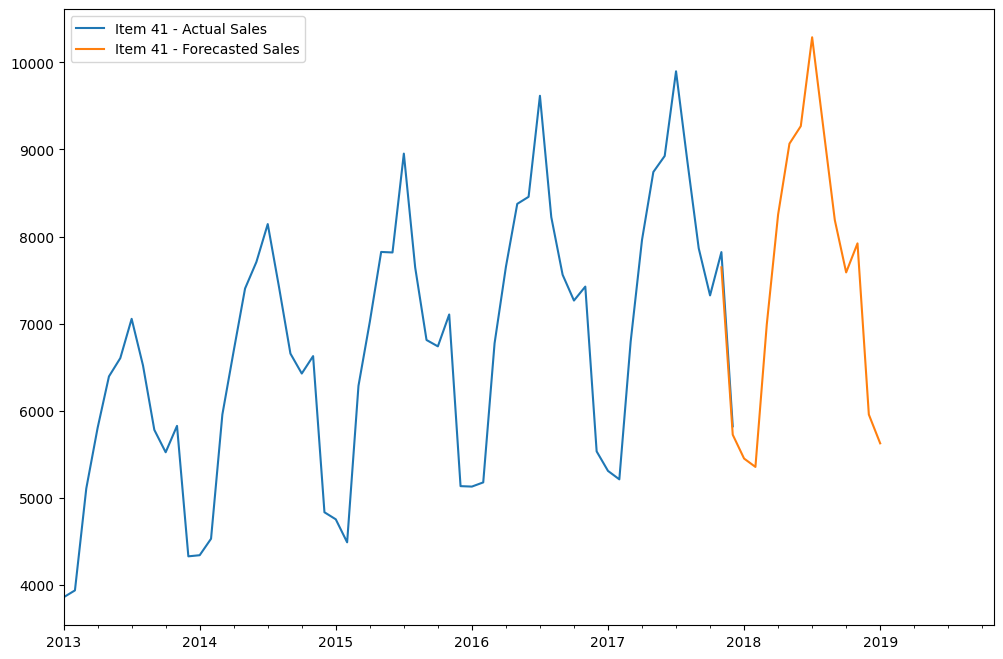

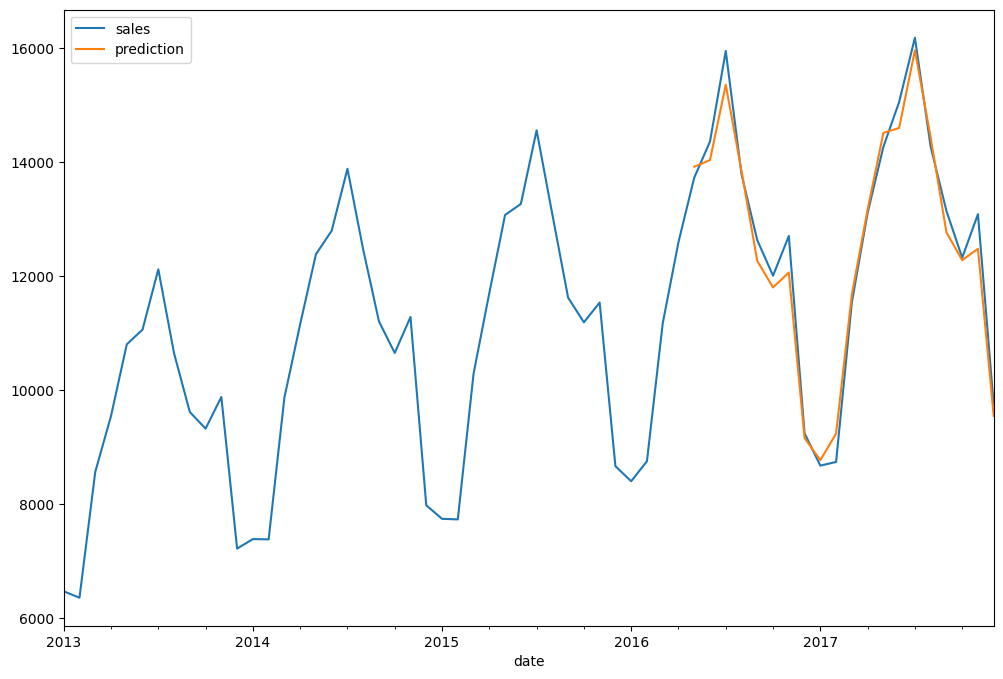

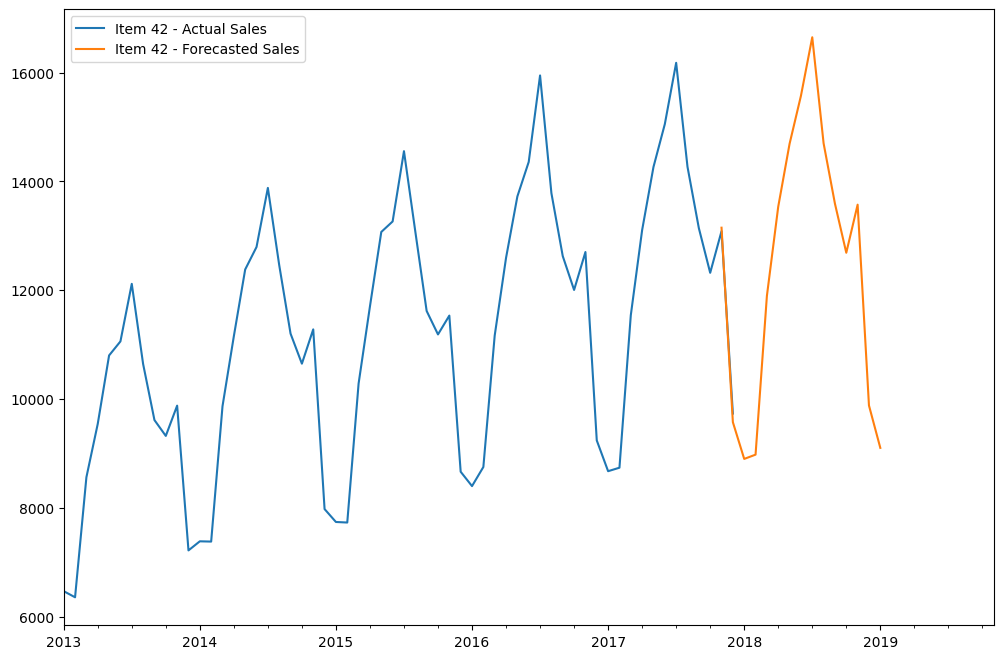

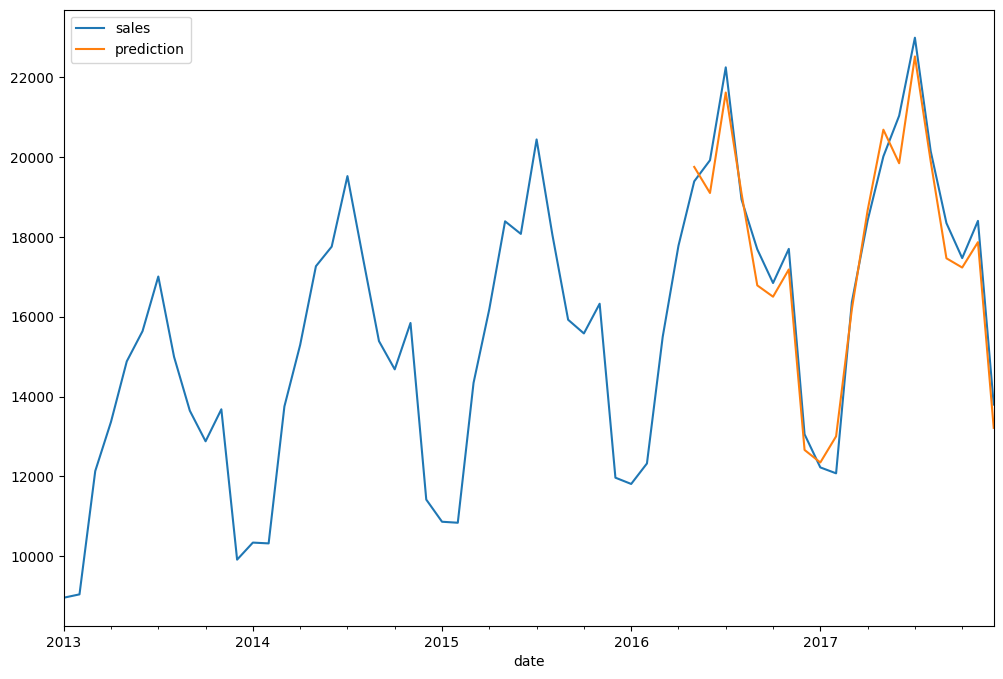

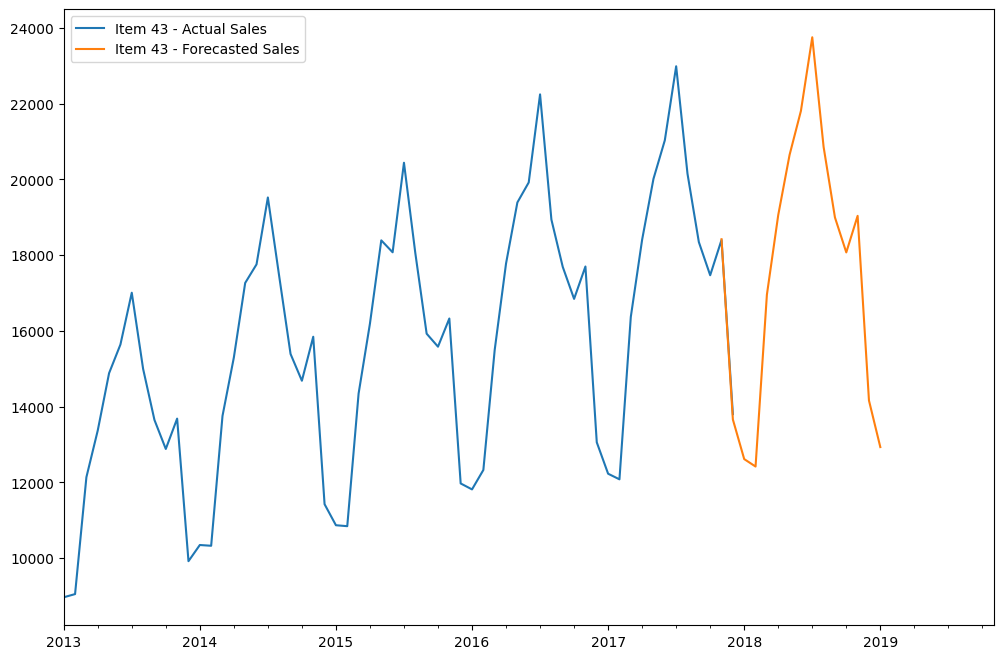

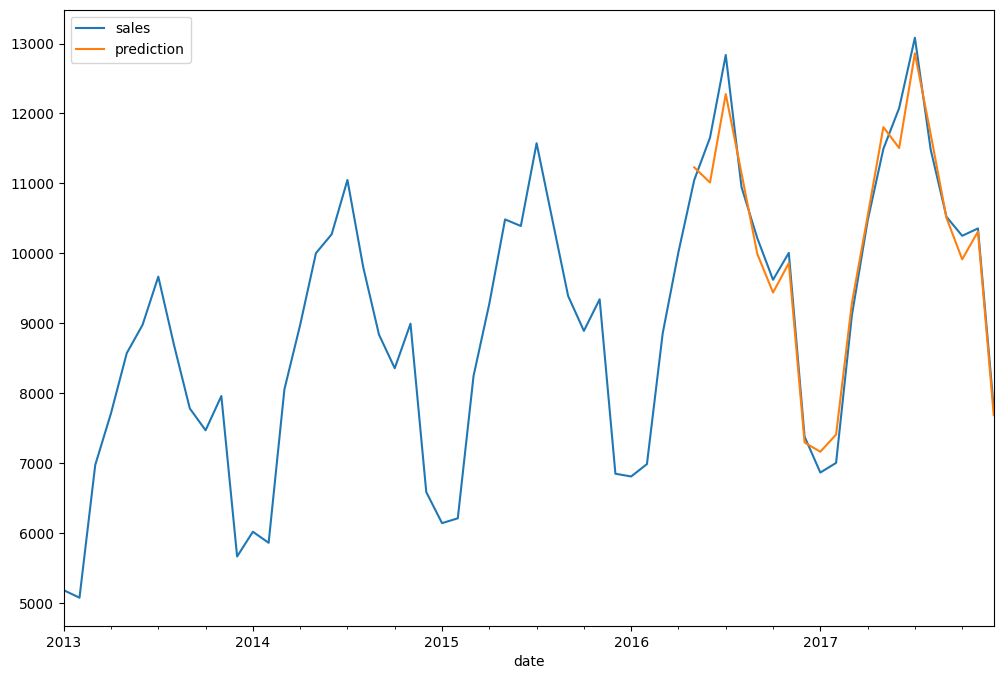

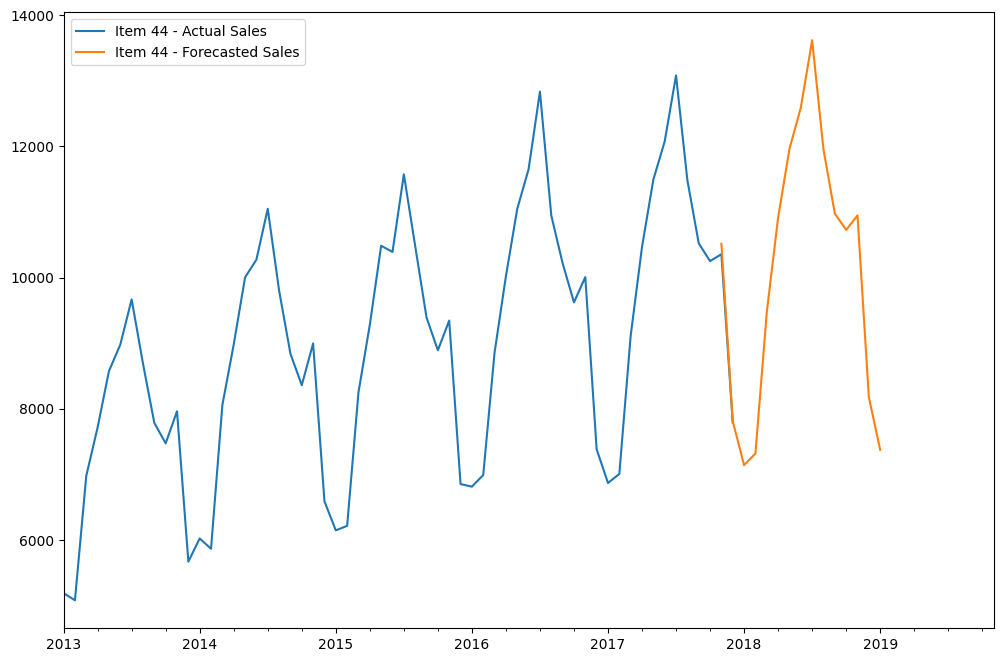

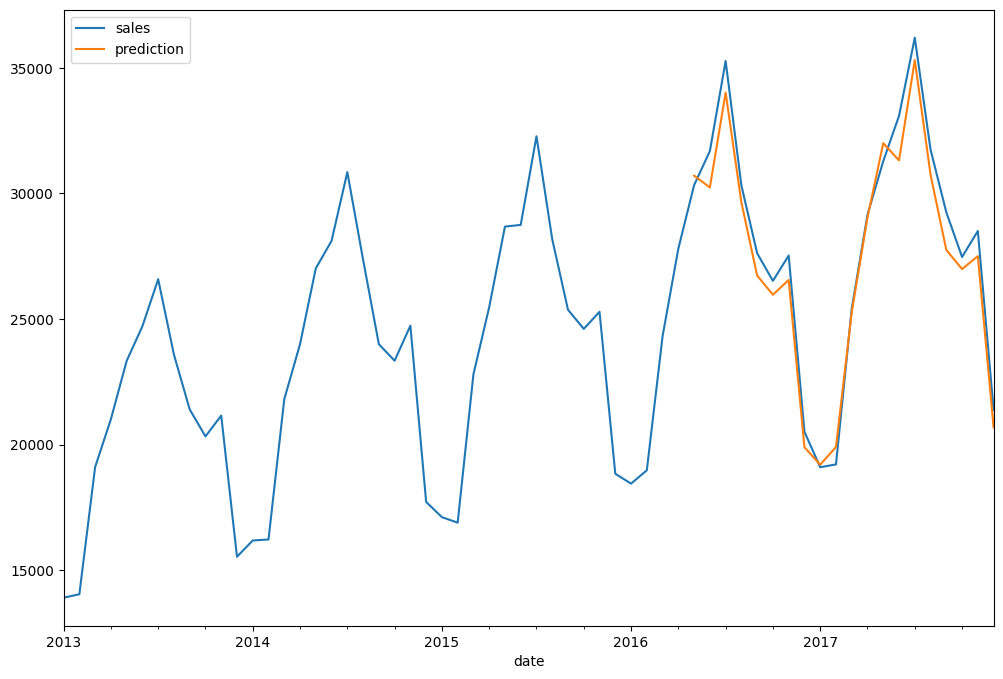

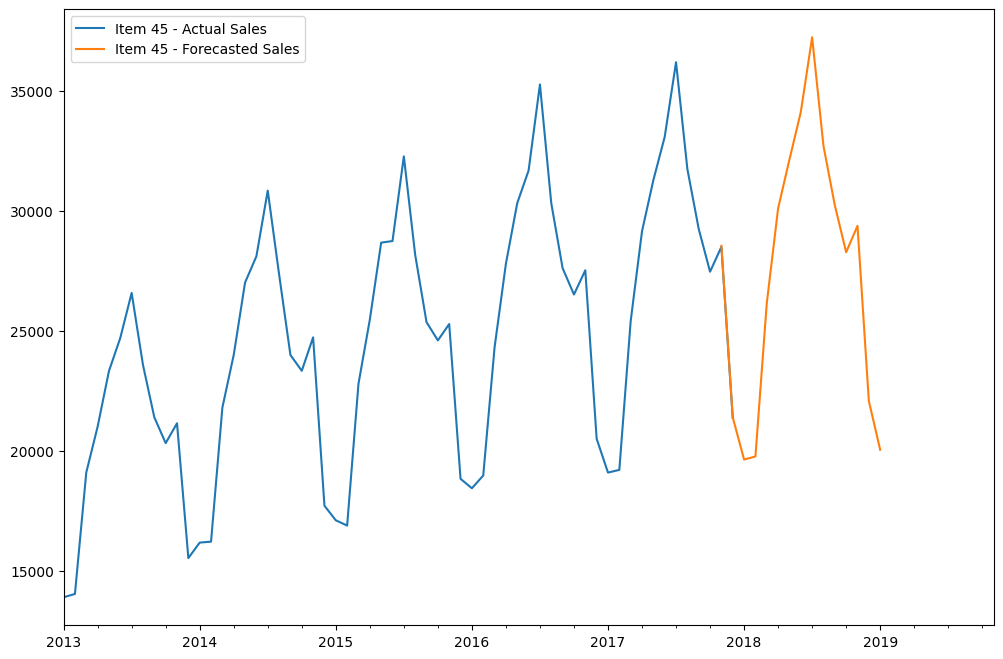

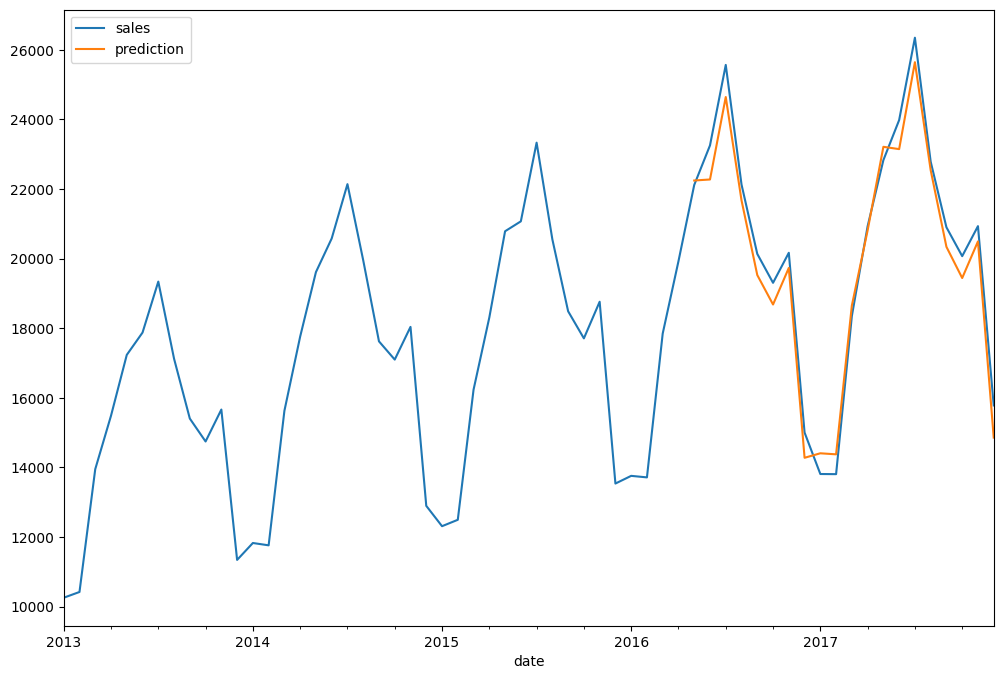

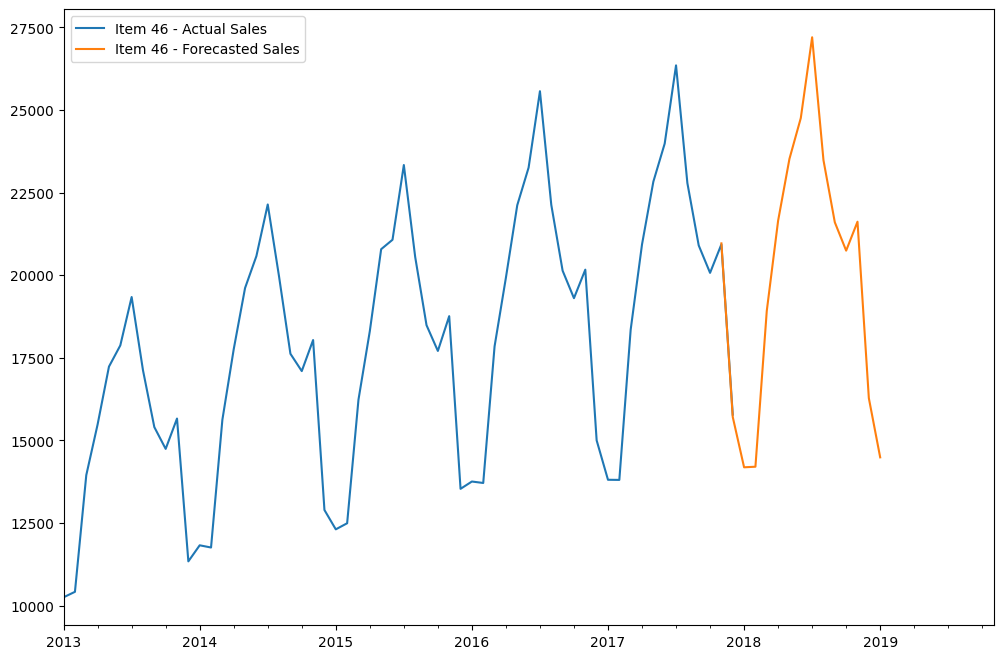

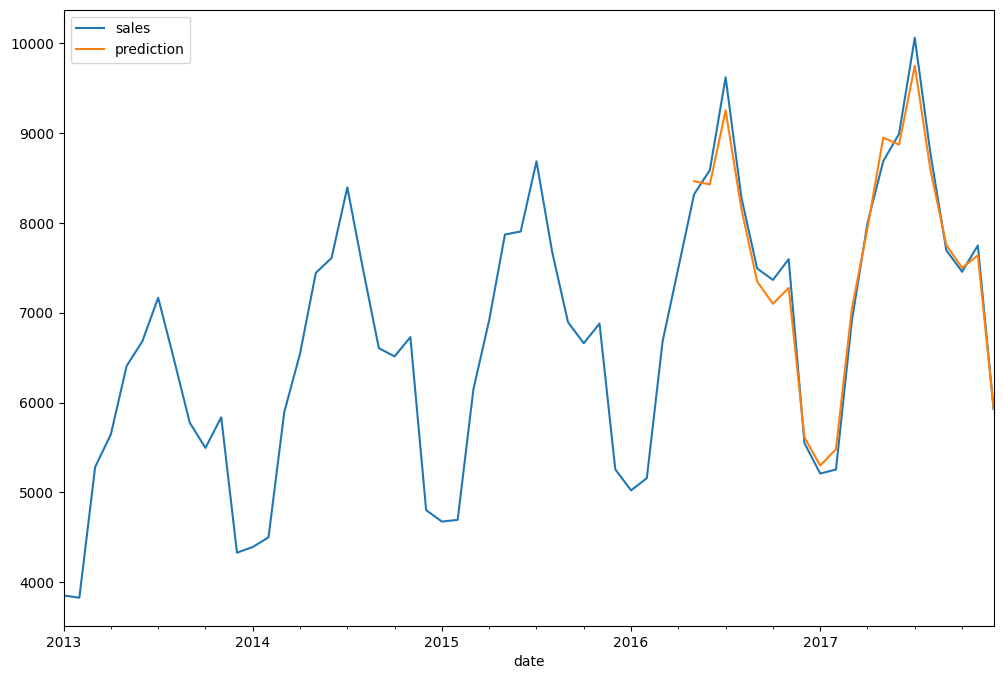

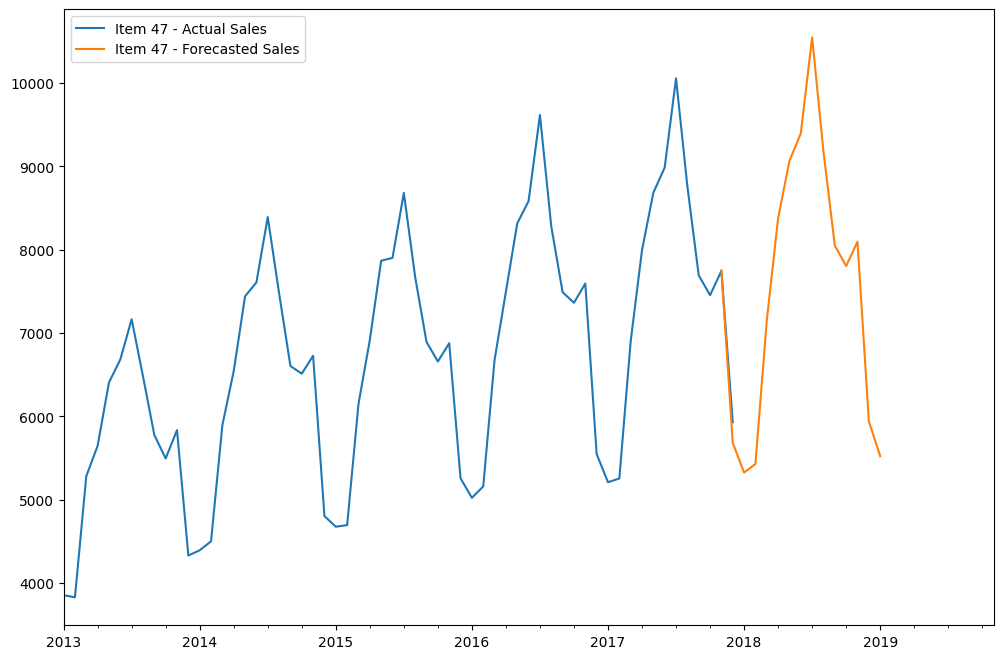

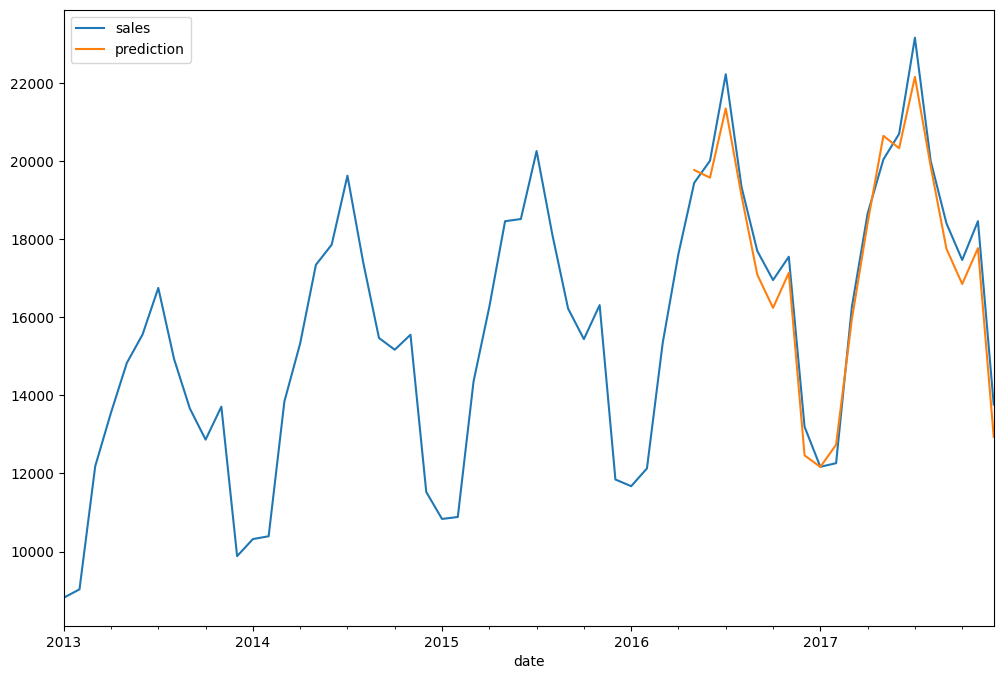

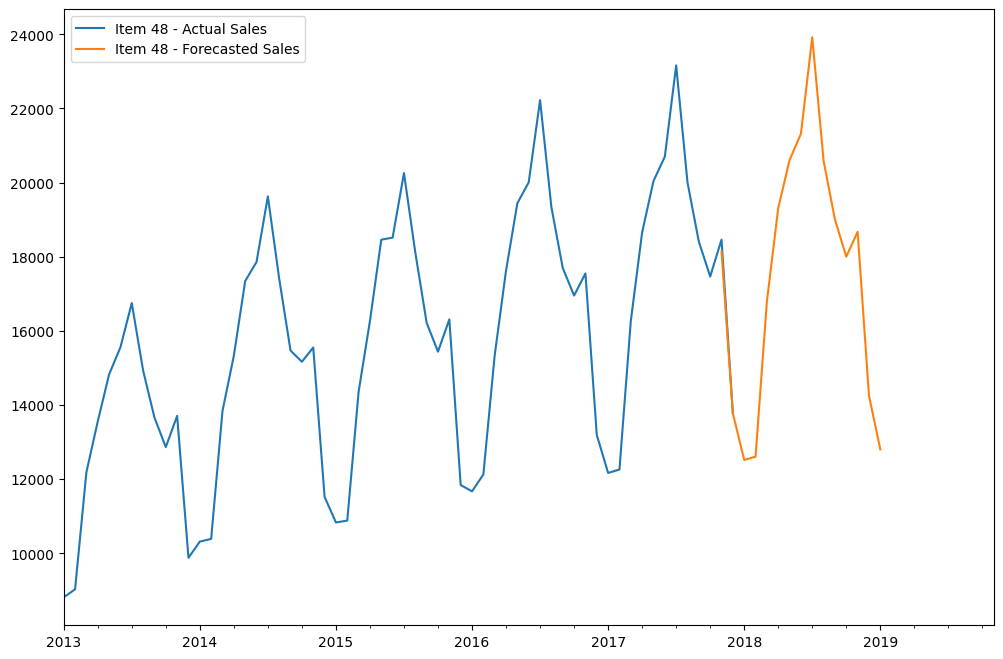

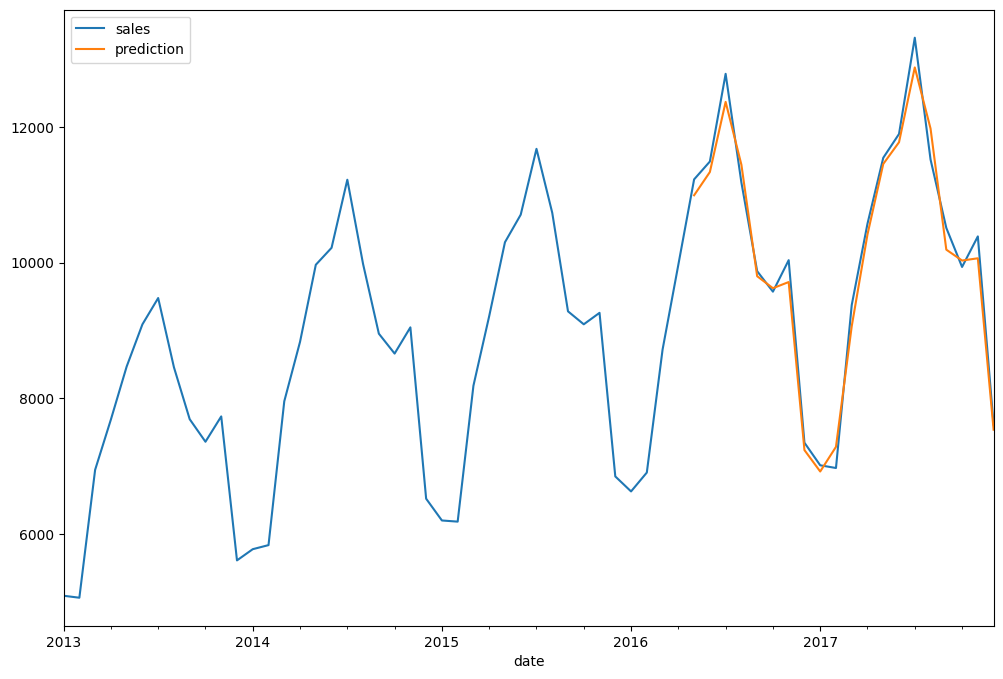

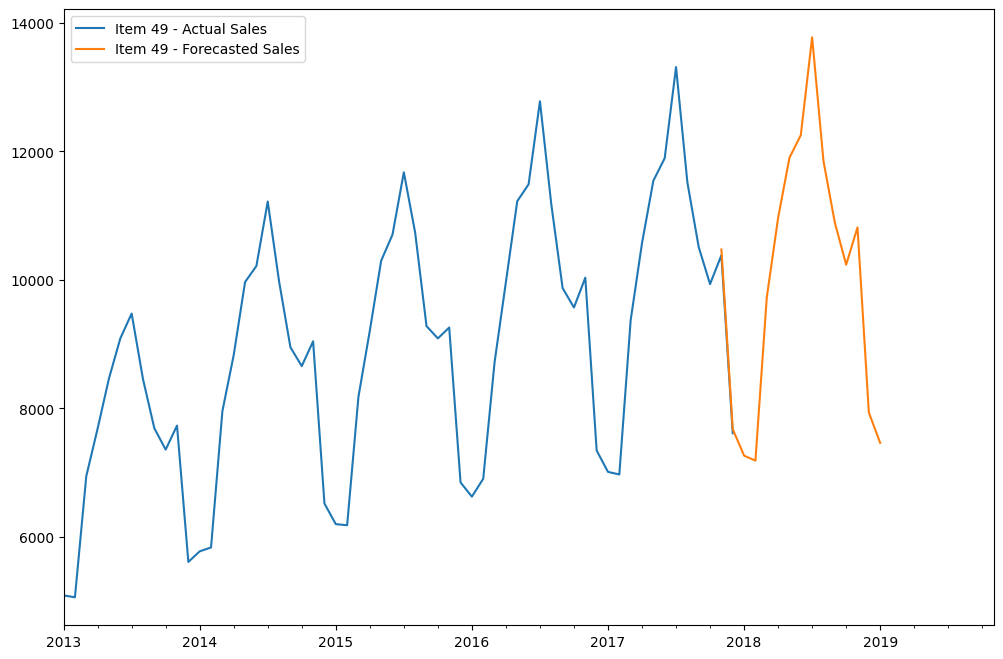

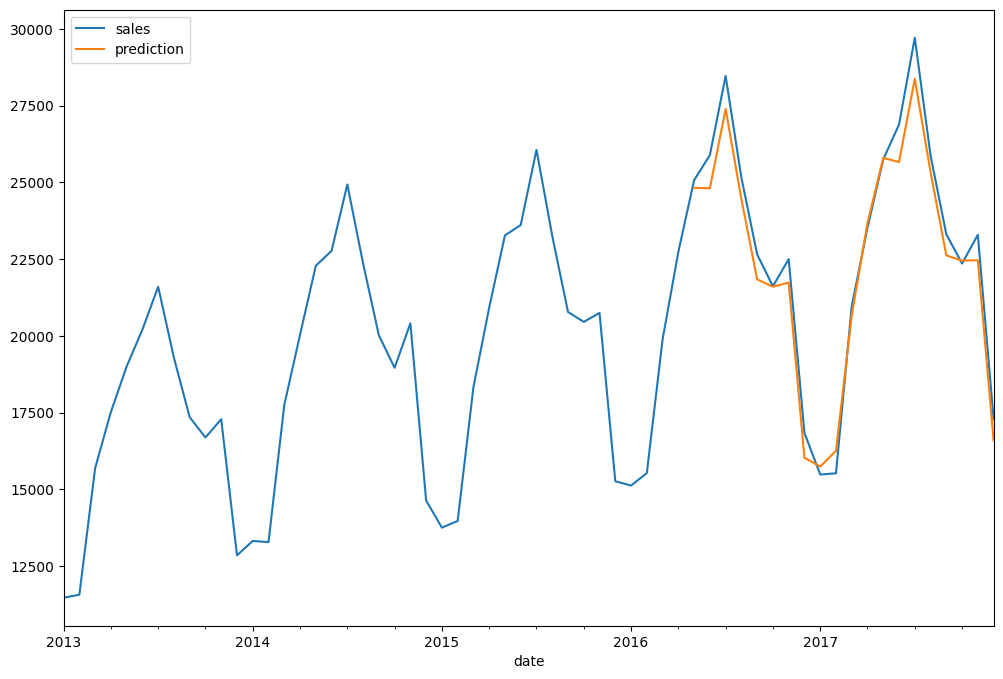

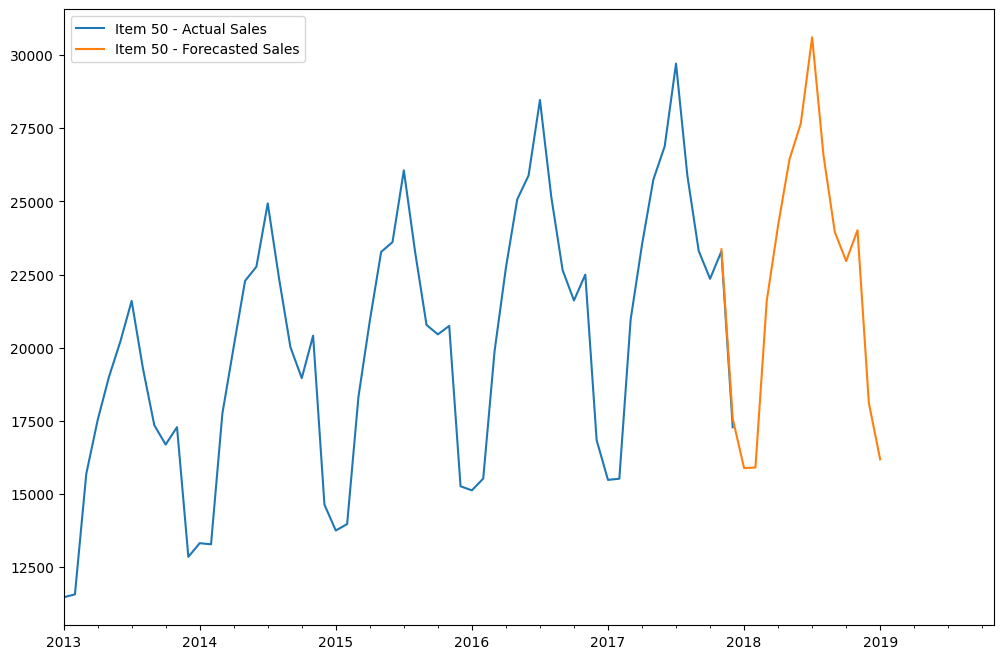

In [18]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pickle
from pandas.tseries.offsets import DateOffset

# Load and preprocess your historical sales data into a DataFrame named 'df'

# Assuming 'df' has columns: 'date', 'item', 'store', 'sales'

# Convert the 'date' column to datetime type
#df['date'] = pd.to_datetime(df['date'])

# Set 'date' as the index
#df.set_index('date', inplace=True)

# Iterate through each item and train/save the SARIMAX model
item_models = {}

for item in df['item'].unique():
    item_data = df[df['item'] == item]
    monthly_sales = item_data.resample('M').sum()

    model = SARIMAX(monthly_sales['sales'],order=(1,0,1), seasonal_order=(1, 1, 1, 12))
    result = model.fit(disp=False)

    item_models[item] = result

    monthly_sales['prediction']=result.predict(start=40,end=59,dynamic=True)
    monthly_sales[['sales','prediction']].plot(figsize=(12,8))

    future_dates=[monthly_sales.index[-1]+ DateOffset(months=x)for x in range(0,24)]
    future_datest_df=pd.DataFrame(index=future_dates[1:],columns=monthly_sales.columns)
    future_df=pd.concat([monthly_sales,future_datest_df])
    future_df['forecast'] = result.predict(start = 58, end = 72, dynamic= True)
    #future_df[['sales', 'forecast']].plot(figsize=(12, 8),legend=item)
    ax = future_df[['sales', 'forecast']].plot(figsize=(12, 8))
    ax.legend([f'Item {item} - Actual Sales', f'Item {item} - Forecasted Sales'])

# Save all trained models to separate pickle files
for item, result in item_models.items():
    with open(f'sarimax_model_{item}.pkl', 'wb') as f:
        pickle.dump(result, f)


In [19]:
from sklearn.metrics import mean_squared_error
RMSE=np.sqrt(mean_squared_error(monthly_sales["sales"].iloc[40:],monthly_sales["prediction"].iloc[40:]))
RMSE

732.6080357088115